# Overview

This computational document looks at the growth of computing in the context of the larger picture of changing student demand, degree production, and instructional workload at UC Berkeley.  

It uses the DataScience tables framework developed for data8, but is not a tutorial document.  It does illustrate the use of tables working across several different data sets to develop insights that are not present from looking at any one of the data sets.

<a id="toc">Table of Contents</a>

* [Data sources](#section_data)
* [University level trends in degrees, majors, and credits](#section_university)
 * [Degrees](#subsection_ucbdegrees)
 * [Majors](#subsection_ucbmajors)
 * [Coruses](#subsection_ucbcourses)
* [UCB productivity and workload per FTE](#UCB_perFTE)
* [Decanal level degrees, majors, and credits](#section_division)
 * [Bachelors degrees](#subsection_BA)
 * [Masters degrees](#subsection_MA)
 * [PhD degrees](#subsection_PhD)
* [Undergraduate trends normalized for overall growth](#section_undergrads)
 * [Degrees](#subsection_degrees)
 * [Majors](#subsection_majors)
 * [Course enrollments](#subsection_credits)
* [Trends within Engineering](#section_engineering)
* [Separating divisions within EECS](#section_eecs)
* [EECS degrees](#section_eecsdegrees)
* [Departmental level trends](#section_dept)
* [Fraction of degrees campus wide](#section_fraction)
* [Degree growth in related programs](#section_related)
* [STEM fields comparison](#section_stem)
* [Departmental breakout for divisions other divisions](#section_breakout)

In [1]:
# HIDDEN
# For Tables reference see http://data8.org/datascience/tables.html
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
import numpy as np
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
# datascience version number of last run of this notebook
version.__version__

'0.5.19'

In [2]:
# Simple tools used in projecting tables.
def sum_cols(tbl, start):
    """Sum the columns of a table from start"""
    csum = 0
    for c in range(start, len(tbl)):
        csum += tbl[c]
    return csum

def sum_rows(tbl, start=1):
    """Sum the rows in a table beyond a start column"""
    return [sum(row[start:]) for row in tbl.rows]

def sort_cols(tbl, start=1):
    """Sort the columns of a table beyond start the values in last row."""
    labels = tbl.labels
    def col_key(label):
        return tbl.row(tbl.num_rows-1)[tbl.labels.index(label)]
    order = sorted(tbl.labels[start:], key=col_key, reverse=True)
    for label in order:
        tbl.move_to_end(label)
    return tbl
        
def top(tbl, n, start=1):
    """Create a new table containing the n largest columns."""
    tmp = tbl.copy()
    sort_cols(tmp, start)
    return tmp.select(tmp.labels[0:n+start])

def sum_collect(s):
    """Collect under sum where possible, then uniform element, then sequence """
    try:
        return sum(s)
    except TypeError:
        if np.all(np.array(s) == s[0]):
            return s[0]
        else:
            return s

def norm_by_row(tbl, base_row=0, start=1):
    """Normalize set of columns by a row"""
    labels = tbl.labels
    normed_tbl = tbl.select(tbl.labels[0:start])
    for label in labels[start:]:
        normed_tbl[label] = tbl[label]/tbl[label][base_row]
    return normed_tbl

def scale_cols(tbl, scale_factor, start=1, skip_start=False):
    """Scale set of columns"""
    labels = tbl.labels
    if skip_start:
        normed_tbl = Table()
    else:
        normed_tbl = tbl.select(tbl.labels[0:start])
    for label in labels[start:]:
        normed_tbl[label] = tbl[label]*scale_factor
    return normed_tbl

<a id="section_data"></a>


# Data

Considerable data is available through the cal-answers data warehouse.  In order to be able to manipulate it, we have extracted raw data from there on measures of productivity, Degrees awarded, which reflect the flow out of the programs, and measures of workload, Majors and student enrollment in classes, i.e., credits.  

The data model rationalizes the University structure in a revealing way.  The decanal unit is a "division".  All schools and most colleges are a single division.  Letters and Science is five divisions.  Divisions have a dean and report to the Provost.  The units within those are termed "Departments", although they may be actual departments or programs or groups.  Departments may have divisions within them, but that is not captured in the data.  To get a handle on such divisional productivity and workload requires inference from other measures.

Separate data sources describe resources.  Here we have only a 2015 FTE snapshot to work with.

As of Aug 26, 2016, the spring 2016 graduation data is not yet available, so this data is already a year old.  With the rate of growth in computing, that is important.  In 2016, the number of L&S CS grads surpassed the number of EECS grads, it became the largest major in L&S, surpassing economics, students tool more computing than all of mathematics or all of engineering, with EE included.  The data here is just prior to those crossovers, but well reflects the longer term underlying trends.

## Degree data

Degree counts are available from cal-answers since 1983.  Here they have been extracted into a csv so we can massage them to produce a departmental level record of student graduations and prorated (sum equals number of students graduating). 

In [3]:
# Different data sets represent the name of the divisions different.  Convert to a common representation.
import re
def normalize_div(div):
    div = re.sub("-", " ", div)
    div = re.sub(" Division", "", div)
    div = re.sub(" Div", "", div)
    div = re.sub("Environmental", "Env", div)
    div = re.sub('L&S Bio Sciences','L&S Biological Sciences', div)
    div = re.sub('L&S Math & Phys Sci', 'L&S Math & Phys Sciences', div)
    div = re.sub('L&S Undergraduate', 'L&S Undergrad Studies', div)
    return div

def normalize_dept(dept):
    dept = re.sub("Comp ", "Computer ", dept)
    dept = re.sub("Rsch", "Research", dept)
    return dept

In [4]:
raw_degrees = Table().read_table("./data/DegreeCounts-1983-2016.csv")  # Raw degree data from CalAnswers
# Only Fall 2105 degrees are represented for 2015-16 AY as of Aug 2016
degree_rows = raw_degrees.where(raw_degrees['Academic Yr'] != '2015-16')
degrees = degree_rows.drop('All Major Acad Hier Level Nm')
degrees.relabel('Academic Yr', 'Year')
degrees.relabel('Academic Department Short Nm', 'Department')
degrees.relabel('Reporting Clg School Short Nm', 'College')
degrees.relabel('Academic Division Short Nm','Division')
degrees.relabel('Student Headcount', 'Grads')
degrees.relabel('Prorated Student Major Cnt Sum', 'Prorated')
degrees['Year'] = degrees.apply(lambda x:int(x[0:4])+1, 'Year') #ending year of AY

degrees['Division'] = degrees.apply(normalize_div, 'Division')
degrees['Department'] = degrees.apply(normalize_dept, 'Department')
degrees

Year | DegLvl | DegLvlDesc | College            | Division           | Department                    | Grads | Prorated
1984 | 1      | Bachelor   | Clg of Chemistry   | Clg of Chemistry   | Chem & Biomolecular Eng       | 123   | 120.5
1984 | 1      | Bachelor   | Clg of Chemistry   | Clg of Chemistry   | Chemistry                     | 42    | 42
1984 | 1      | Bachelor   | Clg of Chemistry   | Clg of Chemistry   | Other Chemistry Programs      | 1     | 1
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Bioengineering                | 4     | 4
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Civil & Environmental Eng     | 78    | 76.5
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Electrical Eng & Computer Sci | 224   | 220.5
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Engineering Science           | 11    | 11
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Industrial Eng & Ops Research | 24    | 22
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Materials Science & Eng       | 25    | 16
1984 | 1      | Bachelor   | Clg of Engineering | Clg of Engineering | Mechanical Engineering        | 153   | 146.5
... (6062 rows omitted)

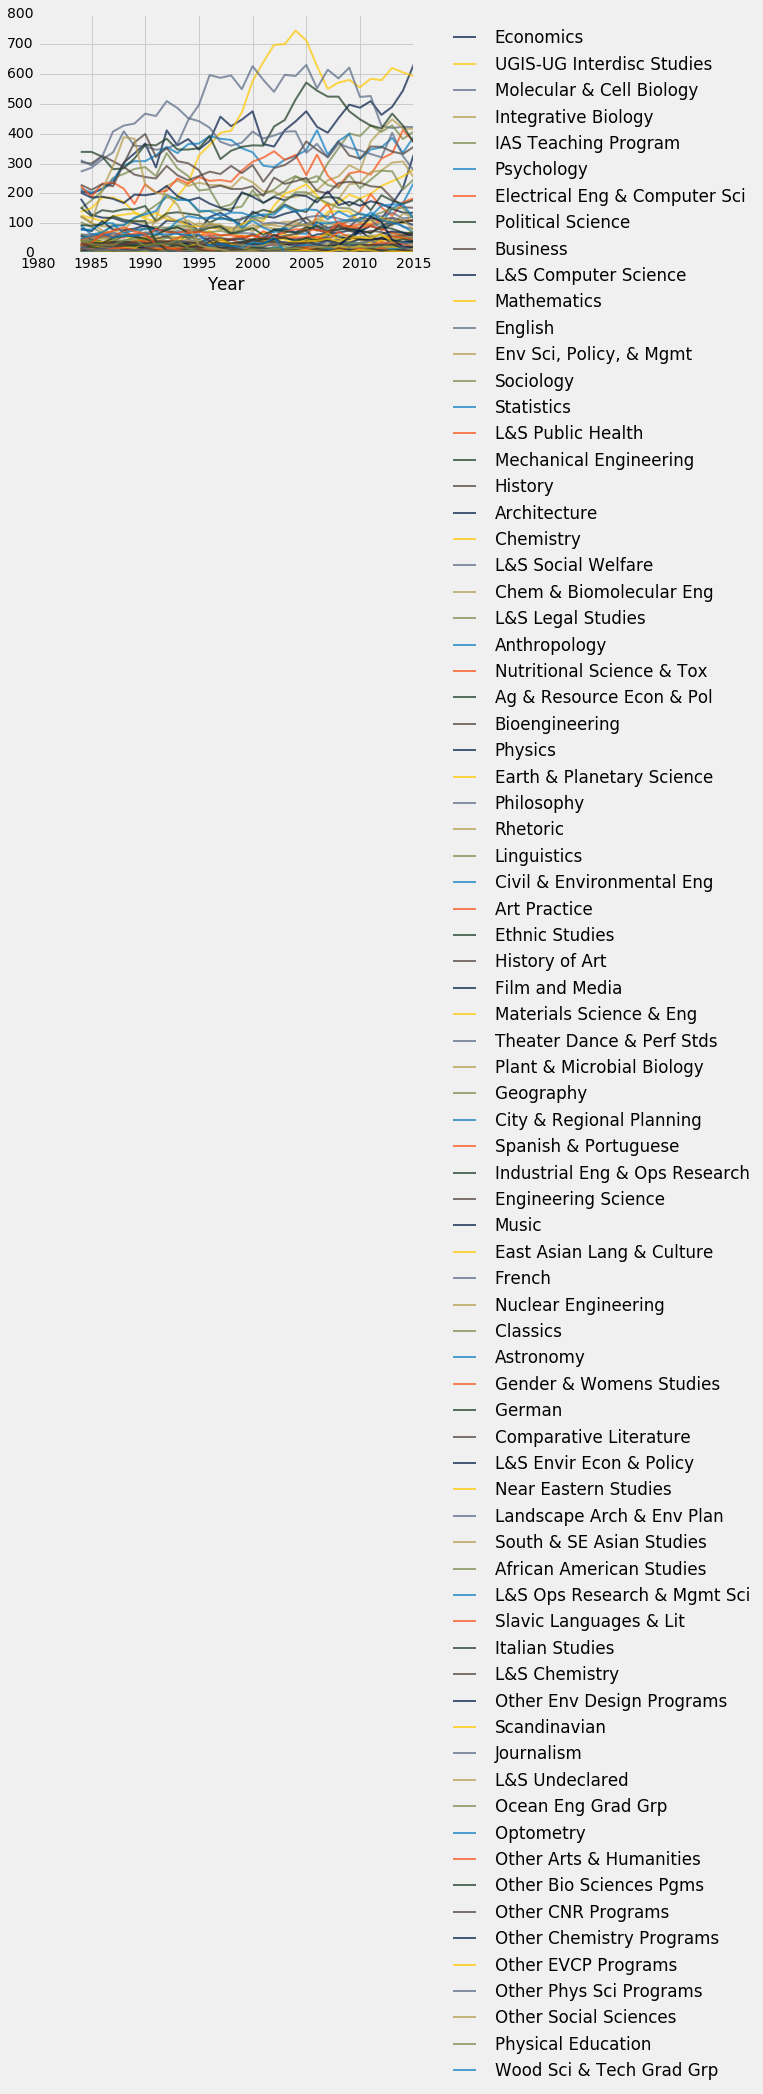

In [5]:
# Crude picture of the overall degree data by department
sort_cols(degrees.where('DegLvl', 1).pivot('Department', 'Year', 'Grads', collect=sum)).plot('Year')

## Majors data

The census of majors reflects one aspect of workload that is closely related to degree production.  It integrates over the cohorts of eventual graduates moving through the program.

In [6]:
raw_majors = Table().read_table("./data/DeptUgradCensus2005-16.csv")

majors = raw_majors.where('Semester Nm', 'Spring').select(['Academic Yr', 'Academic Division Short Nm', 
                                                           'Academic Department Short Nm','Student Headcount',
                                                          'Prorated Student Major Cnt Sum'])
majors.relabel('Academic Yr', 'Year')
majors.relabel('Academic Division Short Nm', 'Division')
majors.relabel('Academic Department Short Nm', 'Department')
majors.relabel('Student Headcount', 'Majors')
majors.relabel('Prorated Student Major Cnt Sum', 'Students')
majors['Year'] = majors.apply(lambda x:int(x[0:4])+1, 'Year')
majors['Division'] = majors.apply(normalize_div, 'Division')
majors['Department'] = majors.apply(normalize_dept, 'Department')

In [7]:
# Small snippet of where we are
majors.where('Year', 2016).groups(['Year', 'Department'], collect=sum_collect).sort('Majors sum_collect', descending=True)

Year | Department                    | Division sum_collect      | Majors sum_collect | Students sum_collect
2016 | L&S Undeclared                | L&S Undeclared            | 8969               | 8969
2016 | Electrical Eng & Computer Sci | Clg of Engineering        | 1196               | 1172.83
2016 | Economics                     | L&S Social Sciences       | 1139               | 961.333
2016 | L&S Computer Science          | L&S Administered Programs | 1083               | 939.167
2016 | Interdisc Social Science Pgms | L&S Social Sciences       | 937                | 846
2016 | Political Science             | L&S Social Sciences       | 834                | 761
2016 | Env Sci, Policy, & Mgmt       | Clg of Natural Resources  | 816                | 783.5
2016 | UG Interdisciplinary Studies  | L&S Undergrad Studies     | 797                | 730.833
2016 | Molecular & Cell Biology      | L&S Biological Sciences   | 793                | 724.5
2016 | Business                      | Haas School of Business   | 673                | 606.5
... (60 rows omitted)

## Enrollment data

Aggregate course enrollments weighted by units is available at the subject level, for 210 subjects. Subjects are roughly at the level of departments, but some departments offer several distinct subjects, e.g., distinct languages, and some subjects are offered by more ad hoc groupings of faculty or multiple departments.

In distilling from the raw data we sum the fall, spring, and summer of each academic year. 

In [8]:
raw_courses = Table().read_table("./data/CourseEnrollments.csv")
courses = raw_courses.select(['Academic Yr', 'Course Subject Short Nm', 'Units'])
courses.relabel('Academic Yr', 'Year')
courses.relabel('Course Subject Short Nm', 'Subject')
courses.relabel('Units', 'Credits')
courses['Year'] = courses.apply(lambda x:int(x[0:4])+1, 'Year')
courses

Year | Subject          | Credits
2016 | Mathematics      | 30254
2015 | Mathematics      | 29553
2016 | Computer Science | 29494
2016 | Computer Science | 28579
2014 | Mathematics      | 27726
2015 | Computer Science | 26296
2016 | Mathematics      | 25682
2015 | Mathematics      | 25612
2012 | Mathematics      | 25435
2013 | Mathematics      | 25342
... (12993 rows omitted)

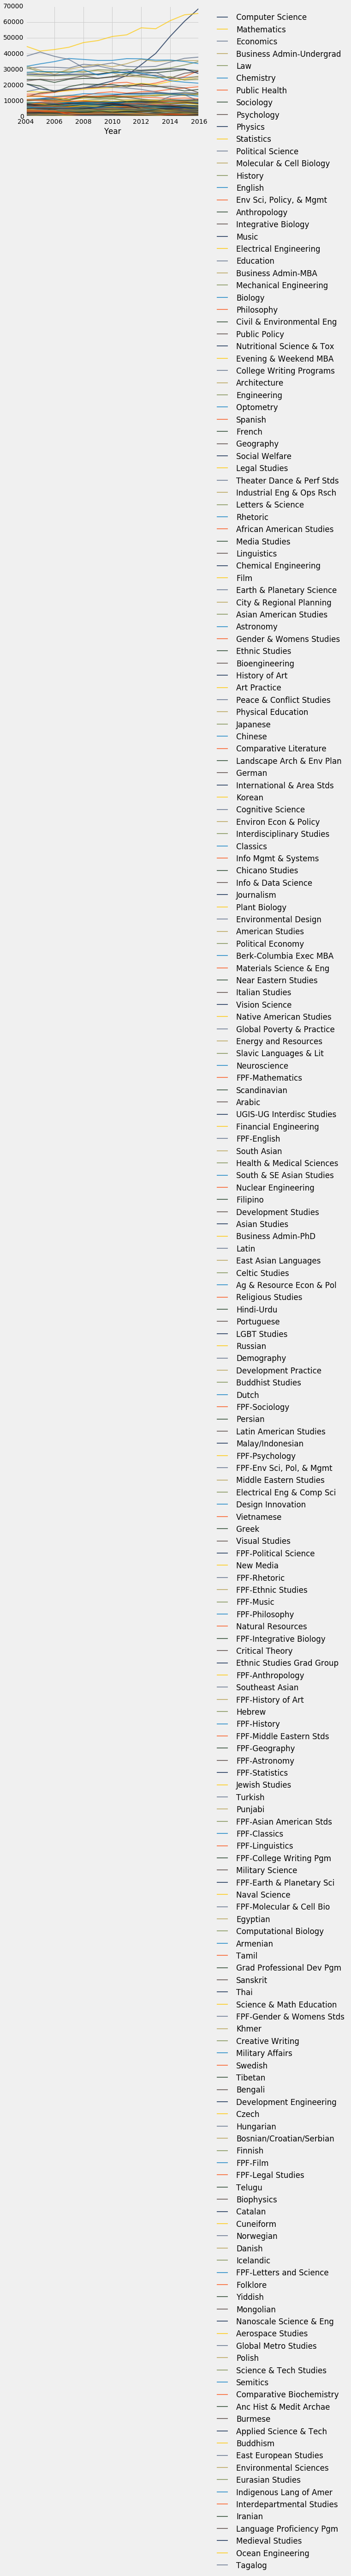

In [9]:
# Crude picture of the overall data - courses by year per subject
courses_by_year = sort_cols(courses.pivot('Subject','Year', 'Credits', collect=sum))
courses_by_year.plot('Year')

In [10]:
courses.where('Year', 2016).groups(['Year', 'Subject'], collect=sum_collect).sort('Credits sum_collect', descending=True).show()

In [11]:
# How many subjects, i.e., fields of study, are recognized
len(np.unique(courses['Subject']))

210

In [12]:
subjects = list(np.unique(courses['Subject']))
subjects

['Aerospace Studies',
 'African American Studies',
 'Ag & Resource Econ & Pol',
 'American Studies',
 'Anc Hist & Medit Archae',
 'Anthropology',
 'Applied Science & Tech',
 'Arabic',
 'Architecture',
 'Armenian',
 'Art Practice',
 'Asian American Studies',
 'Asian Studies',
 'Astronomy',
 'Bengali',
 'Berk-Columbia Exec MBA',
 'Bioengineering',
 'Biology',
 'Biophysics',
 'Bosnian/Croatian/Serbian',
 'Buddhism',
 'Buddhist Studies',
 'Burmese',
 'Business Admin-MBA',
 'Business Admin-PhD',
 'Business Admin-Undergrad',
 'Catalan',
 'Celtic Studies',
 'Chemical Engineering',
 'Chemistry',
 'Chicano Studies',
 'Chinese',
 'City & Regional Planning',
 'Civil & Environmental Eng',
 'Classics',
 'Cognitive Science',
 'College Writing Programs',
 'Comparative Biochemistry',
 'Comparative Literature',
 'Computational Biology',
 'Computer Science',
 'Creative Writing',
 'Critical Theory',
 'Cuneiform',
 'Czech',
 'Danish',
 'Demography',
 'Design Innovation',
 'Development Engineering',
 'Deve

In [13]:
# Create as close a mapping as possible from subject to administrative units
subject_map = Table.read_table("./data/subject-div.csv")
subject_map['Division'] = subject_map.apply(normalize_div, 'Div')
subject_map = subject_map.drop(['Prog', 'Div'])
subject_map['Department'] = subject_map.apply(normalize_dept, 'Dept')
subject_map = subject_map.drop('Dept')
subject_map

Subject                   | Division           | Department
Chemical Engineering      | Clg of Chemistry   | Chem & Biomolecular Eng
Chemistry                 | Clg of Chemistry   | Chemistry
nan                       | Clg of Chemistry   | Chemistry
nan                       | Clg of Chemistry   | Chemistry
nan                       | Clg of Engineering | App Sci & Tech Grad Grp
Bioengineering            | Clg of Engineering | Bioengineering
Civil & Environmental Eng | Clg of Engineering | Civil & Environmental Eng
Computer Science          | Clg of Engineering | Electrical Eng & Computer Sci
Electrical Eng & Comp Sci | Clg of Engineering | Electrical Eng & Computer Sci
Electrical Engineering    | Clg of Engineering | Electrical Eng & Computer Sci
... (225 rows omitted)

## Current FTE Data

FTE date at the start of the 2015-16 year.

In [14]:
raw_fte = Table.read_table("./data/progFTE.csv")

In [15]:
raw_fte

Div                | Dept                      | Prog                      | FTE
Clg of Chemistry   | Chem & Biomolecular Eng   | Chem & Biomolecular Eng   | 16.5
Clg of Chemistry   | Chemistry                 | Chemistry                 | 42
Clg of Chemistry   | Chemistry                 | Other Chemistry Programs  | 0
Clg of Engineering | App Sci & Tech Grad Grp   | App Sci & Tech Grad Grp   | 0
Clg of Engineering | Bioengineering            | Bioengineering            | 19.5
Clg of Engineering | Civil & Environmental Eng | Civil & Environmental Eng | 40.5
Clg of Engineering | Electrical Eng & Comp Sci | Electrical Eng & Comp Sci | 90.5
Clg of Engineering | Engineering Science       | Engineering Science       | 0
Clg of Engineering | Industrial Eng & Ops Rsch | Industrial Eng & Ops Rsch | 14
Clg of Engineering | Materials Science & Eng   | Materials Science & Eng   | 13
... (113 rows omitted)

In [16]:
programs = list(raw_fte['Prog'])

In [17]:
organization = degrees.select(['Division', 'Department']).groups(['Division', 'Department']).drop('count')
organization

Division           | Department
Clg of Chemistry   | Chem & Biomolecular Eng
Clg of Chemistry   | Chemistry
Clg of Chemistry   | Other Chemistry Programs
Clg of Engineering | App Sci & Tech Grad Grp
Clg of Engineering | Bioengineering
Clg of Engineering | Civil & Environmental Eng
Clg of Engineering | Electrical Eng & Computer Sci
Clg of Engineering | Engineering Science
Clg of Engineering | Industrial Eng & Ops Research
Clg of Engineering | Materials Science & Eng
... (113 rows omitted)

In [18]:
fte = raw_fte.with_columns(['Division', raw_fte.apply(normalize_div, 'Div'),
                          'Department', raw_fte.apply(normalize_dept, 'Dept')])
fte = fte.drop(['Div', 'Dept', 'Prog'])
fte.sort('FTE', descending=True)

FTE   | Division                 | Department
90.5  | Clg of Engineering       | Electrical Eng & Computer Sci
82    | Haas School of Business  | Business
72.7  | L&S Biological Sciences  | Molecular & Cell Biology
61.25 | School of Law            | Law
55.25 | L&S Arts & Humanities    | English
49.75 | L&S Math & Phys Sciences | Mathematics
49.25 | L&S Math & Phys Sciences | Physics
49.17 | Clg of Natural Resources | Env Sci, Policy, & Mgmt
47    | L&S Social Sciences      | History
46.75 | School of Public Health  | Public Health
... (113 rows omitted)

In [19]:
total_fte = sum(fte['FTE'])
total_fte

1510.2500000000002

In [20]:
# Group FTE by division, i.e., decanal unit
fte_by_div = fte.group('Division', collect=sum_collect)
fte_by_div.relabel('FTE sum_collect', 'FTE')
fte_by_div.sort('FTE', descending=True).show()

In [21]:
fte_by_dept = fte.group('Department', collect=sum_collect).sort('FTE sum_collect', descending=True)
fte_by_dept.relabel('Division sum_collect', 'Division')
fte_by_dept.relabel('FTE sum_collect', 'FTE')
fte_by_dept.show()

<a id="section_university"></a>[top](#toc)

# University Level trends

<a id="subsection_ucb_degrees"></a>

## Degrees awarded campus wide

The following graph, obtained from the degree data, shows the number of Bachelor, Masters, and PhD degrees awarded campus wide.  Advanced degree data is only available from 1990 on.  This reflects the output of these programs, rather than the effort associated with that output, as different degrees have different duration of residency.

* Today, 7647 undergrad students graduate from 123 programs with 8581 Bachelors degrees, along with 2726 Masters, and 825 PhDs.
* PhD production is fundamentally tied to size of the faculty and mentoring culture in particular fields. The rate of PhD production varies from 719 to 932.  After declines in the 90s it rose sigificantly in 2006, presumably relfecting a return to PhD studies after the Internet boom, and shows recent decline.
* Masters production grew by 30% over 25 years, but 40% since 2000.
* Bachelors degree production has grown 40% since 1990, but nearly 80% since 1985.
* Double degrees appears to have transitioned from a historical rate of ~6% to a recent rate of ~12%.  However, double majors appears to be tracking around ~7%.  This is expected to be lower than degree rate, as major declaration increases with approach to graduation.
* Total number of students and majors has increased 15% over the past decade.
* Credits delivered campus wide has increased 19% over the past decade, the increase reflecting the increasing fraction of undergraduate instruction.
* On average, an FTE produces 0.55 PhDs, 1.8 MS, and 5.7 BAs per year while carrying 17.2 Undergrads in 18.3 majors and providing 688.5 student credit hours.

Year | Bachelor | Doctoral | Masters/Professional
2015 | 8581     | 825      | 2726


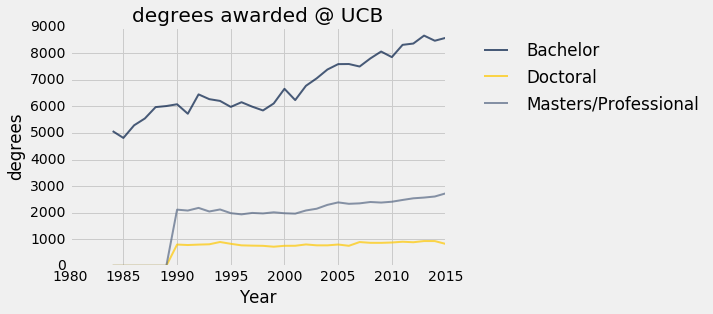

In [22]:
total_degrees = degrees.select(['Year', 'DegLvlDesc', 'Grads', 'Prorated']).groups(['Year', 'DegLvlDesc'],collect=sum)
UCB_grads_by_year = total_degrees.pivot('DegLvlDesc', 'Year', 'Grads sum', collect=sum)
print(UCB_grads_by_year.where('Year', 2015))
UCB_grads_by_year.plot('Year')
#Grads_by_year.show()
plots.title("degrees awarded @ UCB")
plots.ylabel("degrees")

In [23]:
# Degree production per FTE
scale_cols(UCB_grads_by_year.where('Year', 2015), 1/total_fte)

Year | Bachelor | Doctoral | Masters/Professional
2015 | 5.68184  | 0.546267 | 1.805

In [24]:
UCB_prorated_by_year = total_degrees.pivot('DegLvlDesc', 'Year', 'Prorated sum', collect=sum)
print(UCB_prorated_by_year.where('Year', 2015))

Year | Bachelor | Doctoral | Masters/Professional
2015 | 7647     | 825      | 2726


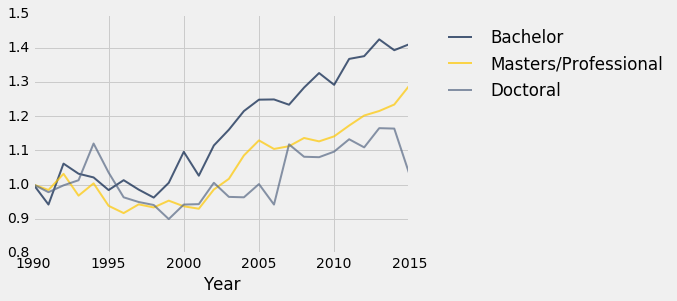

In [25]:
# Relative growth from a base year
base_year = 1990
sort_cols(norm_by_row(UCB_grads_by_year.where(UCB_grads_by_year['Year']>=base_year))).plot('Year')

In [26]:
# Number of distnct degrees
len(np.unique(degrees['Department']))

123

Year | Grads sum | Prorated sum
2015 | 8581      | 7647


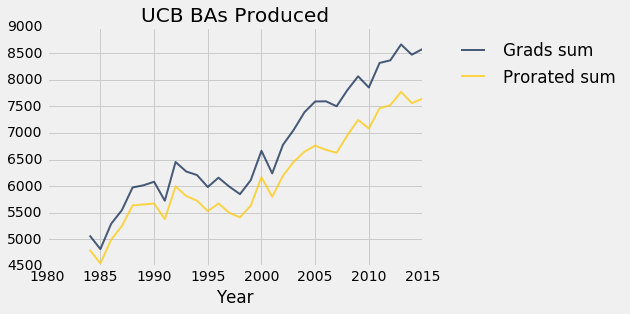

In [27]:
# Bachelors degrees by decanal unit, i.e., Division
BAs = degrees.where('DegLvl', 1).select(['Year', 'Grads', 'Prorated'])
BAs_by_year = BAs.group('Year', collect=sum)
print(BAs_by_year.where('Year', 2015))
BAs_by_year.plot('Year')
_ = plots.title("UCB BAs Produced")

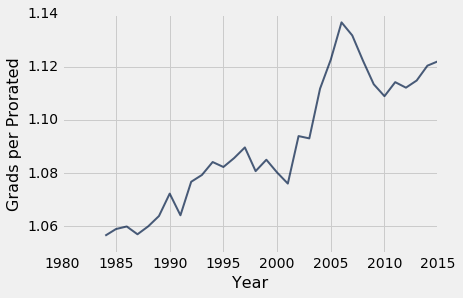

In [28]:
BAs_by_year.with_column('Grads per Prorated', BAs_by_year['Grads sum']/BAs_by_year['Prorated sum']).select(['Year', 'Grads per Prorated']).plot('Year')

## Majors campus wide

The total number of students and majors has grown by 15% over the past 10 years.  On average 6% carry double majors, and this has remained relatively constant campus wide, although it is highly concentrated in certain disciplines - primarily those related to data science as discussed below.

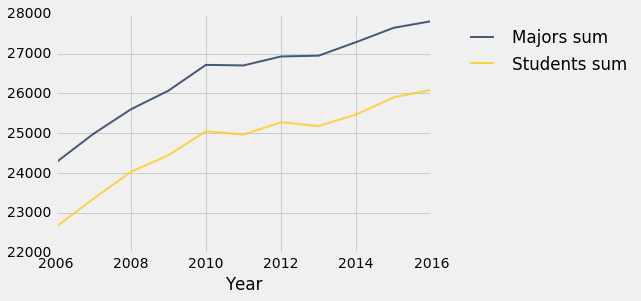

In [29]:
# Undergraduate Students and Majors
UCB_majors_by_year = majors.select(['Year', 'Majors', 'Students']).group('Year', collect=sum)
UCB_majors_by_year.plot('Year')

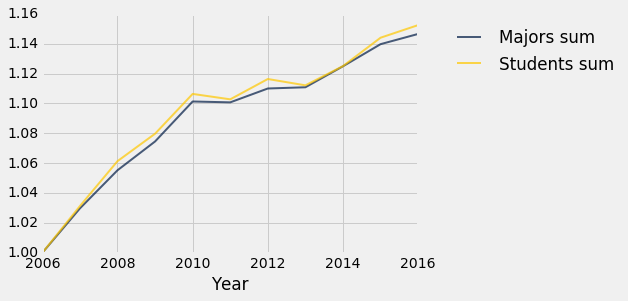

In [30]:
norm_by_row(UCB_majors_by_year).plot('Year')

In [31]:
majors_per_student_by_year = UCB_majors_by_year.select('Year').with_column('Major per student', 
                                                                             UCB_majors_by_year['Majors sum']/UCB_majors_by_year['Students sum'])
majors_per_student_by_year.show()

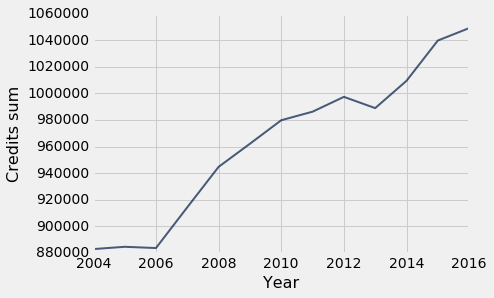

In [32]:
# Total student credit hours delivered campus wide
UCB_courses_by_year = courses.drop('Subject').group('Year', collect=sum)
UCB_courses_by_year.plot('Year')

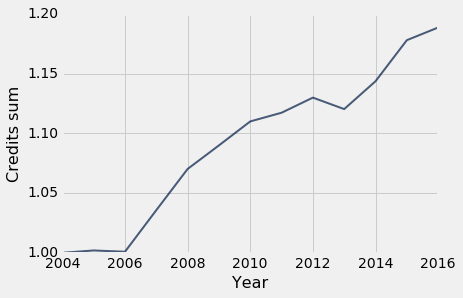

In [33]:
norm_by_row(UCB_courses_by_year).plot('Year')

In [34]:
# Overall picture of UCB campus wide production and workload
ucb_by_year = UCB_grads_by_year.join('Year', UCB_prorated_by_year).join('Year', UCB_majors_by_year).join('Year', UCB_courses_by_year)
ucb_by_year

Year | Bachelor | Doctoral | Masters/Professional | Bachelor_2 | Doctoral_2 | Masters/Professional_2 | Majors sum | Students sum | Credits sum
2006 | 7597     | 753      | 2334                 | 6683       | 753        | 2333                   | 24260      | 22643        | 883582
2007 | 7503     | 894      | 2351                 | 6629       | 894        | 2346                   | 24981      | 23351        | 914280
2008 | 7808     | 865      | 2402                 | 6957       | 865        | 2400                   | 25600      | 24032        | 944721
2009 | 8067     | 864      | 2381                 | 7245       | 864        | 2380                   | 26068      | 24448        | 962121
2010 | 7857     | 877      | 2412                 | 7085       | 877        | 2411                   | 26717      | 25051        | 979834
2011 | 8319     | 906      | 2479                 | 7466       | 905        | 2480                   | 26703      | 24969        | 986259
2012 | 8368     | 887      | 2541                 | 7524       | 887        | 2541                   | 26928      | 25277        | 997417
2013 | 8667     | 932      | 2569                 | 7774       | 932        | 2568                   | 26948      | 25181        | 988950
2014 | 8474     | 931      | 2609                 | 7563       | 930        | 2610                   | 27289      | 25473        | 1.00952e+06
2015 | 8581     | 825      | 2726                 | 7647       | 825        | 2726                   | 27648      | 25903        | 1.03984e+06

<a id="UCB_perFTE"></a>

<a id="subsection_ucb_perfte"></a>[top](#toc)

## Campus-wide average production and workload per FTE

In [35]:
# Production and workload per FTE
FTE_output = scale_cols(ucb_by_year.where('Year', 2015), 1/total_fte)
FTE_output

Year | Bachelor | Doctoral | Masters/Professional | Bachelor_2 | Doctoral_2 | Masters/Professional_2 | Majors sum | Students sum | Credits sum
2015 | 5.68184  | 0.546267 | 1.805                | 5.0634     | 0.546267   | 1.805                  | 18.3069    | 17.1515      | 688.525

In [36]:
BAs2015_per_fte = FTE_output["Bachelor"][0]
BAs2015_per_fte

5.6818407548419119

In [37]:
MAs2015_per_fte = FTE_output['Masters/Professional'][0]
MAs2015_per_fte

1.8049991723224628

In [38]:
PhDs2015_per_fte = FTE_output['Doctoral'][0]
PhDs2015_per_fte

0.54626717430888916

In [39]:
# Average number of declared majors per FTE
majors2016_per_fte = sum(majors.where(majors['Division'] != 'L&S Undeclared').where('Year', 2016)['Majors'])/total_fte
majors2016_per_fte

12.478066545273959

In [40]:
credits2016_per_fte = FTE_output['Credits sum'][0]
credits2016_per_fte

688.52474755835112

### Mapping from course subjects to organizational entitites

Cal-Answers provides SCH per subject, from nearly 200 subjects, that align in a complicated fashion with departments and programs.  A small portion of the issue is interdisciplinary programs.  Many small departments have many distinct subjects.  Many departments have many programs and many of those have no subjects.  Painfully, we have built a mapping that is quite close. 

In [41]:
subject_map

Subject                   | Division           | Department
Chemical Engineering      | Clg of Chemistry   | Chem & Biomolecular Eng
Chemistry                 | Clg of Chemistry   | Chemistry
nan                       | Clg of Chemistry   | Chemistry
nan                       | Clg of Chemistry   | Chemistry
nan                       | Clg of Engineering | App Sci & Tech Grad Grp
Bioengineering            | Clg of Engineering | Bioengineering
Civil & Environmental Eng | Clg of Engineering | Civil & Environmental Eng
Computer Science          | Clg of Engineering | Electrical Eng & Computer Sci
Electrical Eng & Comp Sci | Clg of Engineering | Electrical Eng & Computer Sci
Electrical Engineering    | Clg of Engineering | Electrical Eng & Computer Sci
... (225 rows omitted)

In [42]:
courses_by_dept = courses.join('Subject', subject_map).drop('Prog')
courses_by_dept

Subject           | Year | Credits | Division              | Department
Aerospace Studies | 2005 | 54      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2006 | 50      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2007 | 46      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2004 | 43      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2006 | 36      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2006 | 36      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2011 | 36      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2004 | 35      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2005 | 33      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
Aerospace Studies | 2004 | 30      | L&S Undergrad Studies | UGIS-UG Interdisc Studies
... (12753 rows omitted)

<a id="section_division"></a>

## Trends in degree programs and the divisional, i.e., decanal, level

The broader trends among large majors provide an important backdrop.  
* Social Sciences experienced huge growth in the late 80's and has retained its size.  
* Humanities saw a similar 30% growth, but has decreased markedly over the recent few years.  
* L&S Undergraduate division, which is primarily interdisciplinary programs delivered by departments in other L&S divisions has grown steadily.  
* Biological Sciences saw large growth in the 90's, after the reorganization of of Biology settled in.
* Engineering has grown slowly.  
* L&S Administered programs, which contains 7 majors with other colleges or schools, has grown substantially since 2000. It is predominantly computer science.
* L&S Math and Physical Science has grown substantially since the downturn, as has the College of Natural Resources.
* Distributing the administered program degrees and majors back to their originiating divisions presents a rather different picture, especially for the College of Engineering, because CS is so large.
* Normalizing for the size of the faculty in each division, Engineering is essentially at campus average degree production, while Biological Sciences and Social Sciences BA productivity are higher, as is Social Welfare, but it is a very small program.  Humanities falls substantially below.

Collectively, we see how the last 10 years is dominated by growth in STEM, whereas Humanities and Social Sciences saw their growth in the late 80's, just as the first large boom in Computer Science ended.

In [43]:
np.unique(degrees.where('Division', 'L&S Administered Programs')['Department'])

array(['L&S Chemistry', 'L&S Computer Science', 'L&S Envir Econ & Policy',
       'L&S Legal Studies', 'L&S Ops Research & Mgmt Sci',
       'L&S Public Health', 'L&S Social Welfare'], 
      dtype='<U29')

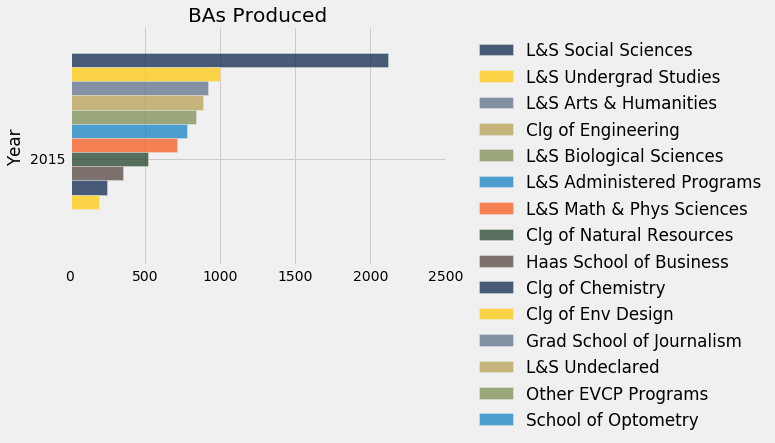

In [44]:
# Bachelors degrees by decanal unit, i.e., Division
BAs_Div = degrees.where('DegLvl', 1).select(['Year','Division','Grads'])
div_BAs_by_year = BAs_Div.pivot('Division', 'Year', 'Grads', collect=sum)
sort_cols(div_BAs_by_year).where('Year',2015).barh('Year')
_ = plots.title("BAs Produced")

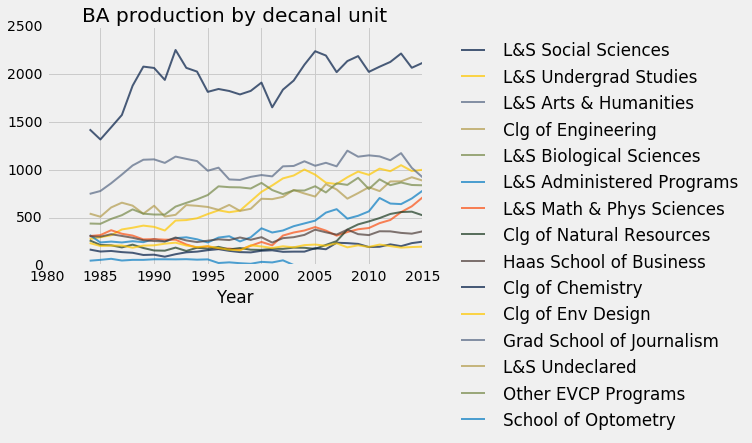

In [45]:
div_BAs_by_year.plot('Year', linewidth=2)
_ = plots.title("BA production by decanal unit")

L&S Administered programs are degree programs provided by other colleges and schools, but administered through L&S because schools do not grant undergraduate degrees and because some programs are both naturally in Engineering and in a liberaal arts eduction.

In [46]:
admin_program_degree_map = Table(['Degree', 'Division']).with_rows(
    [('L&S Chemistry', 'Clg of Chemistry'),
    ('L&S Computer Science', 'Clg of Engineering'),
    ('L&S Envir Econ & Policy', 'Clg of Natural Resources'),
    ('L&S Legal Studies', 'School of Law'),
    ('L&S Ops Research & Mgmt Sci', 'Clg of Engineering'),
    ('L&S Public Health', 'School of Public Health'),
    ('L&S Social Welfare', 'School of Social Welfare')
    ])

def map_div(division, dept):
    if division == 'L&S Administered Programs':
        for (deg, div) in admin_program_degree_map.rows:
            if deg == dept:
                return div
    return division

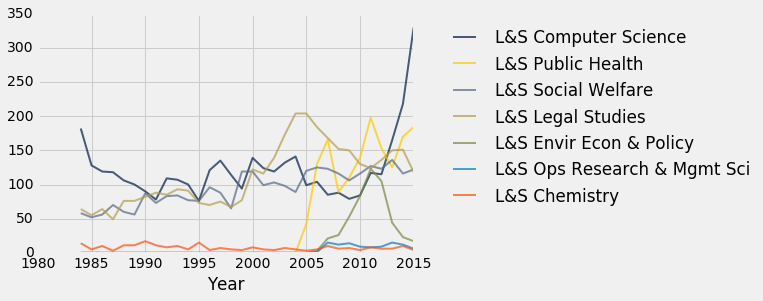

In [47]:
sort_cols(degrees.where('Division', 'L&S Administered Programs').select(['Year', 'Department', 'Grads']).pivot('Department', 'Year', 'Grads', collect=sum)).plot('Year')

<a id="subsection_BA"></a>

### Bachelors degrees by decanal unit with L&S administered attributed to originating division

In [48]:
# Revised degree data table cross divisional attribution
revised_degrees = degrees.with_column('Division', degrees.apply(map_div, ['Division', 'Department']))

With L&S administered programs attributed to their home division, we see a rather different picture of the relative undergraduate production.  College of Engineering rises above all divisions but Social Sciences, primarily due to its provision of computer science.

Importantly, the other programs, while smaller, have an increasingly computational element with the broader aspect of data science.

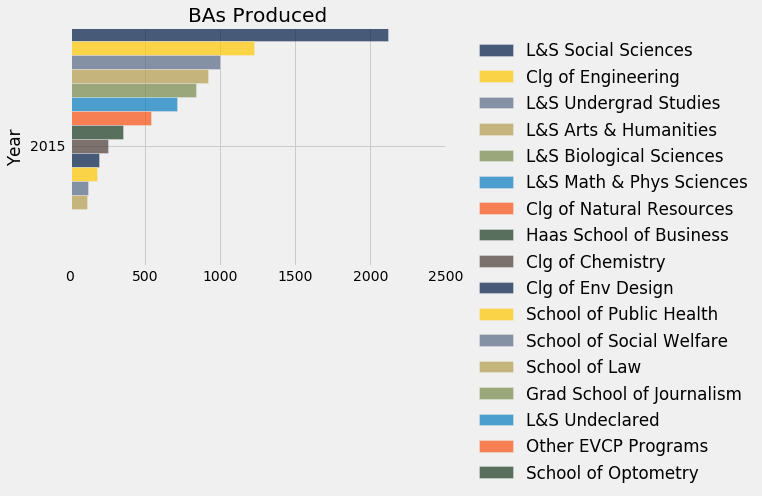

In [49]:
rBAs_Div = revised_degrees.where('DegLvl', 1).select(['Year','Division','Grads'])
rdiv_BAs_by_year = rBAs_Div.pivot('Division', 'Year', 'Grads', collect=sum)
sort_cols(rdiv_BAs_by_year).where('Year',2015).barh('Year')
_ = plots.title("BAs Produced")

With this adjustment, we can see more clearly the change over the past 5 years:
* rise of Engineering undergraduate production due to computer science, and
* the corresponding rise in Math and Physical Sciences due to confluent interests in other aspects of data science, statistics and applied math.

We also see:
* the prior growth in the College of Natural Resources 2006-2012
* the growth of Biological Sciences, following the reorganization, throughout the 90's
* the growth in the late 80's of Social Science and Arts and Humanities.

The overall growth of the undergraduate program has so far allowed individual divisions to maintain degree production while other divisions experience growth.

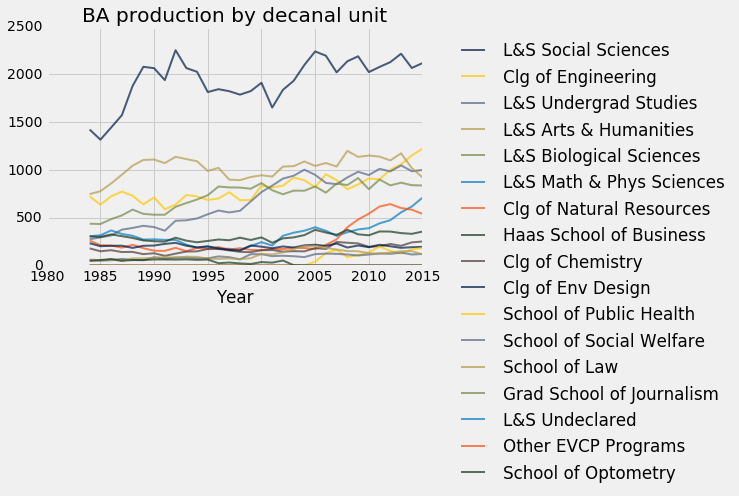

In [50]:
rdiv_BAs_by_year.plot('Year', linewidth=2)
_ = plots.title("BA production by decanal unit")

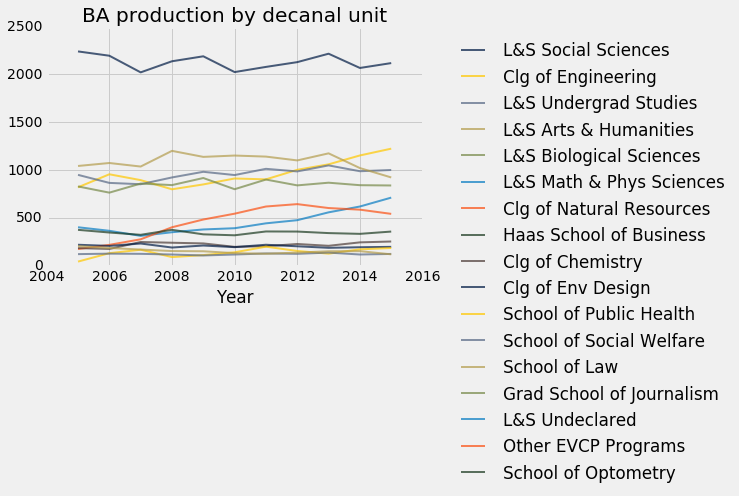

In [51]:
rdiv_BAs_by_year.where(rdiv_BAs_by_year['Year'] >= 2005).plot('Year', linewidth=2)
_ = plots.title("BA production by decanal unit")

### Normalizing for size of the faculty

While the graph above shows the relative trends clearly, it leaves open the question of whether the size of the faculty across the divisions is aligned with the productivity or workload of the programs.

In [52]:
def norm_col_by_tbl(tbl, scale_table, norm_label, norm_value, start = 1):
    """Scale set of columns by value in a scaling table. """
    labels = tbl.labels
    normed_tbl = tbl.select(tbl.labels[0:start])
    for label in labels[start:]:
        scale_row = scale_table.where(norm_label, label)[norm_value]
        if len(scale_row) == 1:
            normed_tbl[label] = tbl[label]/scale_row[0]
    return normed_tbl

In [53]:
sort_cols(div_BAs_by_year.where('Year', 2015))

Year | L&S Social Sciences | L&S Undergrad Studies | L&S Arts & Humanities | Clg of Engineering | L&S Biological Sciences | L&S Administered Programs | L&S Math & Phys Sciences | Clg of Natural Resources | Haas School of Business | Clg of Chemistry | Clg of Env Design | Grad School of Journalism | L&S Undeclared | Other EVCP Programs | School of Optometry
2015 | 2118                | 1000                  | 922                   | 887                | 838                     | 781                       | 711                      | 524                      | 356                     | 248              | 196               | 0                         | 0              | 0                   | 0

In [54]:
# Grads per FTE
sort_cols(norm_col_by_tbl(div_BAs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE'))

Year | L&S Undergrad Studies | L&S Biological Sciences | L&S Social Sciences | L&S Math & Phys Sciences | Clg of Natural Resources | Haas School of Business | Clg of Chemistry | Clg of Engineering | L&S Arts & Humanities | Clg of Env Design | Grad School of Journalism | L&S Undeclared | Other EVCP Programs | School of Optometry
2015 | 333.333               | 7.90939                 | 7.86046             | 4.79595                  | 4.77014                  | 4.34146                 | 4.23932          | 3.91611            | 3.82573               | 3.73333           | 0                         | nan            | 0                   | 0

In [55]:
# Grads after distributing administered programs to offered division
sort_cols(rdiv_BAs_by_year.where('Year', 2015))

Year | L&S Social Sciences | Clg of Engineering | L&S Undergrad Studies | L&S Arts & Humanities | L&S Biological Sciences | L&S Math & Phys Sciences | Clg of Natural Resources | Haas School of Business | Clg of Chemistry | Clg of Env Design | School of Public Health | School of Social Welfare | School of Law | Grad School of Journalism | L&S Undeclared | Other EVCP Programs | School of Optometry
2015 | 2118                | 1223               | 1000                  | 922                   | 838                     | 711                      | 541                      | 356                     | 252              | 196               | 184                     | 122                      | 118           | 0                         | 0              | 0                   | 0

In [56]:
BAs2015_per_fte_by_div = sort_cols(norm_col_by_tbl(rdiv_BAs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE'))
BAs2015_per_fte_by_div

Year | L&S Undergrad Studies | L&S Biological Sciences | L&S Social Sciences | School of Social Welfare | Clg of Engineering | Clg of Natural Resources | L&S Math & Phys Sciences | Haas School of Business | Clg of Chemistry | School of Public Health | L&S Arts & Humanities | Clg of Env Design | School of Law | Grad School of Journalism | L&S Undeclared | Other EVCP Programs | School of Optometry
2015 | 333.333               | 7.90939                 | 7.86046             | 7.625                    | 5.39956            | 4.9249                   | 4.79595                  | 4.34146                 | 4.30769          | 3.93583                 | 3.82573               | 3.73333           | 1.92653       | 0                         | nan            | 0                   | 0

In [57]:
BAs2015_per_fte

5.6818407548419119

In [58]:
# Ratio of Grads per FTE to campus average
scale_cols(BAs2015_per_fte_by_div, 1/BAs2015_per_fte, 2, True)

L&S Biological Sciences | L&S Social Sciences | School of Social Welfare | Clg of Engineering | Clg of Natural Resources | L&S Math & Phys Sciences | Haas School of Business | Clg of Chemistry | School of Public Health | L&S Arts & Humanities | Clg of Env Design | School of Law | Grad School of Journalism | L&S Undeclared | Other EVCP Programs | School of Optometry
1.39205                 | 1.38343             | 1.34199                  | 0.950319           | 0.866779                 | 0.844084                 | 0.764095                | 0.758151         | 0.692703                | 0.673325              | 0.657064          | 0.339068      | 0                         | nan            | 0                   | 0

From this normalization we can see that Engineering as a whole is essentially campus average in degree undergraduate degree production per FTE (largely due to its computer science program, as shown below), with Biology, Social Science, and Social Welfare delivering about 4/3rds the average per FTE.

<a id="subsection_MA"></a>

## Masters degrees by decanal unit, i.e., Division

At the masters level, we see profound growth amongst Business, Law, and Engineering over the past decade, with modest and mostly steady rate across the rest.

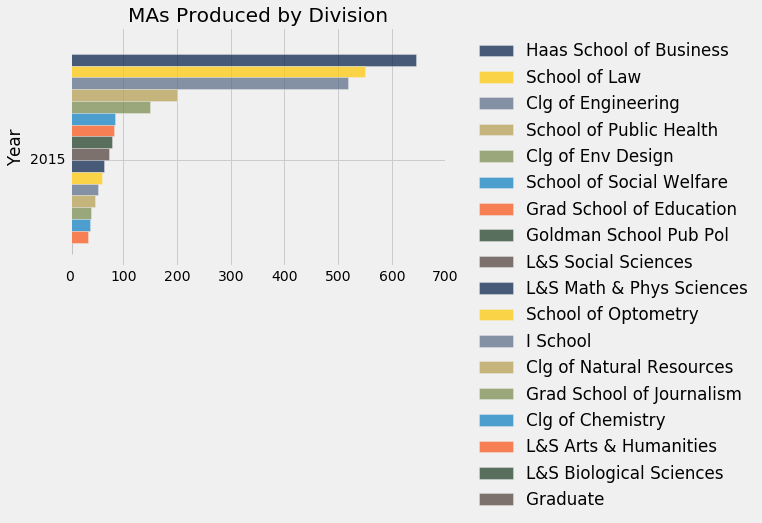

In [59]:
MAs_Div = degrees.where('DegLvl', 2).select(['Year','Division','Grads'])
div_MAs_by_year = sort_cols(MAs_Div.pivot('Division', 'Year', 'Grads', collect=sum))
div_MAs_by_year.where('Year',2015).barh('Year')
_ = plots.title("MAs Produced by Division")

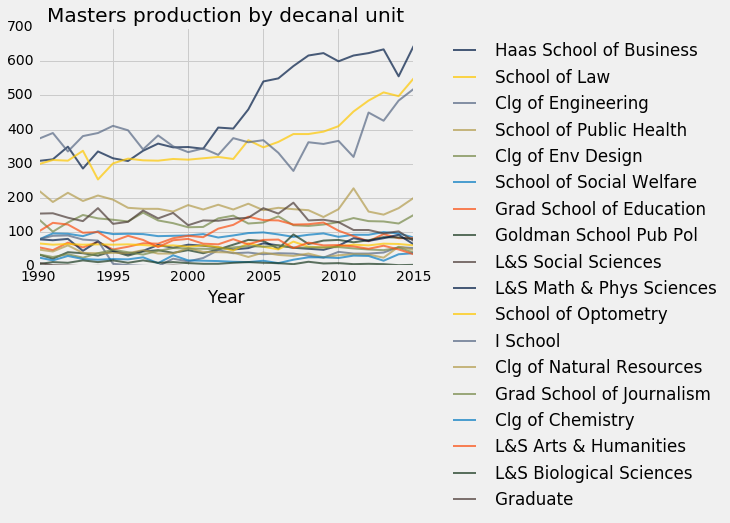

In [60]:
div_MAs_by_year.plot('Year')
_ = plots.title("Masters production by decanal unit")

In [61]:
# MAs production
div_MAs_by_year.where('Year',2015)

Year | Haas School of Business | School of Law | Clg of Engineering | School of Public Health | Clg of Env Design | School of Social Welfare | Grad School of Education | Goldman School Pub Pol | L&S Social Sciences | L&S Math & Phys Sciences | School of Optometry | I School | Clg of Natural Resources | Grad School of Journalism | Clg of Chemistry | L&S Arts & Humanities | L&S Biological Sciences | Graduate
2015 | 645                     | 550           | 519                | 200                     | 150               | 84                       | 82                       | 79                     | 74                  | 64                       | 61                  | 53       | 48                       | 40                        | 38               | 35                    | 4                       | 0

In [62]:
# MAs per FTE
sort_cols(norm_col_by_tbl(div_MAs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE'))

Year | School of Law | Haas School of Business | School of Social Welfare | Grad School of Journalism | I School | School of Public Health | Goldman School Pub Pol | School of Optometry | Grad School of Education | Clg of Env Design | Clg of Engineering | Clg of Chemistry | Clg of Natural Resources | L&S Math & Phys Sciences | L&S Social Sciences | L&S Arts & Humanities | L&S Biological Sciences | Graduate
2015 | 8.97959       | 7.86585                 | 5.25                     | 4.44444                   | 4.41667  | 4.27807                 | 4.27027                | 4.06667             | 2.90265                  | 2.85714           | 2.29139            | 0.649573         | 0.436959                 | 0.431703                 | 0.274634            | 0.145228              | 0.0377537               | nan

In [63]:
# Relative to campus norm
scale_cols(sort_cols(norm_col_by_tbl(div_MAs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE')), 1/MAs2015_per_fte)

Year | School of Law | Haas School of Business | School of Social Welfare | Grad School of Journalism | I School | School of Public Health | Goldman School Pub Pol | School of Optometry | Grad School of Education | Clg of Env Design | Clg of Engineering | Clg of Chemistry | Clg of Natural Resources | L&S Math & Phys Sciences | L&S Social Sciences | L&S Arts & Humanities | L&S Biological Sciences | Graduate
2015 | 4.97485       | 4.35782                 | 2.90859                  | 2.4623                    | 2.44691  | 2.37013                 | 2.3658                 | 2.253               | 1.60812                  | 1.58291           | 1.26947            | 0.359874         | 0.242083                 | 0.239171                 | 0.152152            | 0.0804589             | 0.0209162               | nan

<a id="subsection_PhD"></a>

## PhDs by Decanal unit (i.e., division)

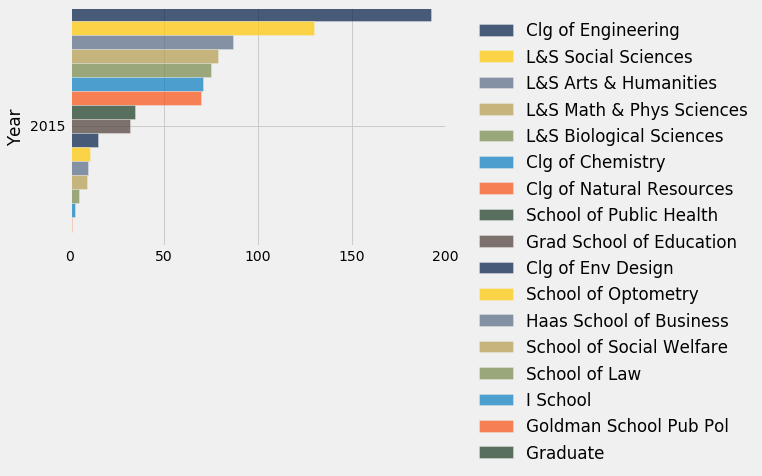

In [64]:
# PhDs degrees by decanal unit, i.e., Division
Ps_Div = degrees.where('DegLvl', 3).select(['Year','Division','Grads'])
div_PhDs_by_year = sort_cols(Ps_Div.pivot('Division', 'Year', 'Grads', collect=sum))
div_PhDs_by_year.where('Year', 2015).barh('Year')

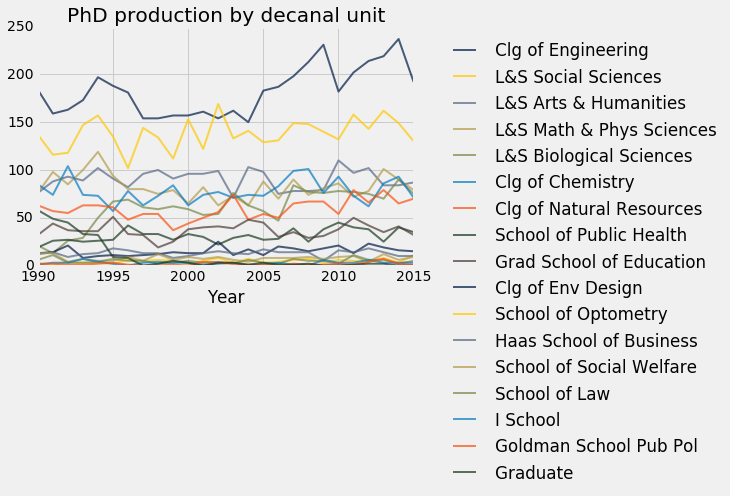

In [65]:
div_PhDs_by_year.plot('Year')
_ = plots.title("PhD production by decanal unit")

In [66]:
div_PhDs_by_year.where('Year', 2015)

Year | Clg of Engineering | L&S Social Sciences | L&S Arts & Humanities | L&S Math & Phys Sciences | L&S Biological Sciences | Clg of Chemistry | Clg of Natural Resources | School of Public Health | Grad School of Education | Clg of Env Design | School of Optometry | Haas School of Business | School of Social Welfare | School of Law | I School | Goldman School Pub Pol | Graduate
2015 | 192                | 130                 | 87                    | 79                       | 75                      | 71               | 70                       | 35                      | 32                       | 15                | 11                  | 10                      | 9                        | 5             | 3        | 1                      | 0

In [67]:
sort_cols(norm_col_by_tbl(div_PhDs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE'))

Year | Clg of Chemistry | Grad School of Education | Clg of Engineering | School of Public Health | School of Optometry | L&S Biological Sciences | Clg of Natural Resources | School of Social Welfare | L&S Math & Phys Sciences | L&S Social Sciences | L&S Arts & Humanities | Clg of Env Design | I School | Haas School of Business | School of Law | Goldman School Pub Pol | Graduate
2015 | 1.21368          | 1.13274                  | 0.847682           | 0.748663                | 0.733333            | 0.707881                | 0.637233                 | 0.5625                   | 0.532884                 | 0.482464            | 0.360996              | 0.285714          | 0.25     | 0.121951                | 0.0816327     | 0.0540541              | nan

In [68]:
scale_cols(sort_cols(norm_col_by_tbl(div_PhDs_by_year.where('Year', 2015), fte_by_div, 'Division', 'FTE')), 1/PhDs2015_per_fte)

Year | Clg of Chemistry | Grad School of Education | Clg of Engineering | School of Public Health | School of Optometry | L&S Biological Sciences | Clg of Natural Resources | School of Social Welfare | L&S Math & Phys Sciences | L&S Social Sciences | L&S Arts & Humanities | Clg of Env Design | I School | Haas School of Business | School of Law | Goldman School Pub Pol | Graduate
2015 | 2.22176          | 2.07361                  | 1.55177            | 1.37051                 | 1.34244             | 1.29585                 | 1.16652                  | 1.02972                  | 0.9755                   | 0.883202            | 0.660841              | 0.52303           | 0.457652 | 0.223245                | 0.149437      | 0.0989517              | nan

<a id="section_undergrads"></a>

## Undergraduate trends normalized for overall growth


Given the growth in the total number of degrees, we normalize to separate shifts from overall growth.

For the past 25 years we have 
* a steady decline in social science and humanities, 
* after a rise in the 90's, biology steady
* L&S growth is primarily interdisiplinary programs and math and physical sciences
* recent growth in engineering, dominated by computer science,
* growth in math and physical sciences, dominated by statistics
* growth in CNR during 2000-2010 that has reversed since

Over the past 10 years where he have Major data, these trends are consistent and more pronounced

Normalizing for size of the faculty, Engineering (and MPS) are average campus wide while Social Sciences remains a heavier per_FTE undergraduate rate, but in both cases these figures are dominated by heavy loads in particular fields - computer science and economics, respectively.

Taking this down to course credits, the dominant trend is the growth of computer science, now exceeding Math despite near doubling of Math demands, whereas 10 years ago it was less than half.

<a id="subsection_degrees"></a>

### Degrees

Over the past 30 years, the undergraduate program has grown 70% while the faculty size and PhD program has remained roughly constant.  A better sense of student choice is obtained by normalizing for overall growth in the student population.

The growth in degree rate (and majors) is not exactly the growth in student population because the increase in junior transfers increases the size of the cohort in the upper division.

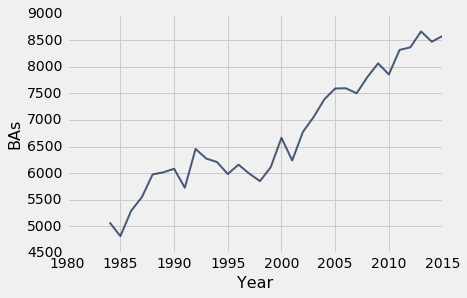

In [69]:
UCB_grads_by_year.select(['Year', 'Bachelor']).relabel('Bachelor', 'BAs').plot('Year')

In [70]:
UCB_grads_by_year['Bachelor'][-1]/UCB_grads_by_year['Bachelor'][0]

1.6921711693945967

In [71]:
def normalize_table(by_year):
    normed_by_year = by_year.select('Year')
    total_by_year = sum_rows(by_year)
    for label in by_year.labels[1:] :
        normed_by_year[label] = by_year[label] / total_by_year
        normed_by_year.set_format(label, PercentFormatter)
    return normed_by_year

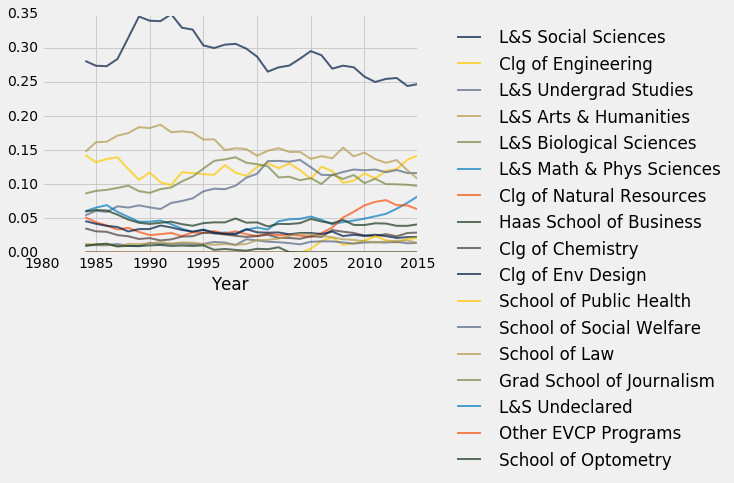

In [72]:
# 30 year trend in degrees as a fraction of overall campus wide production
normalize_table(rdiv_BAs_by_year).plot('Year')

In [73]:
def forecast_table(by_year_table, past, years):
    last_year = int(by_year_table['Year'][-1])
    past_years = range(last_year+1 - past, last_year+1) # window over fit
    fore_years = range(last_year+1, last_year+1+years) # projection
    def project(lbl):
        m,b = np.polyfit(past_years, by_year_table[lbl][-past-1:-1], 1)
        return [m*year + b for year in fore_years]
    xtbl = Table().with_columns([('Year', fore_years)] + [(label, project(label)) for label in by_year_table.labels[1:]])
    return by_year_table.copy().append(xtbl)

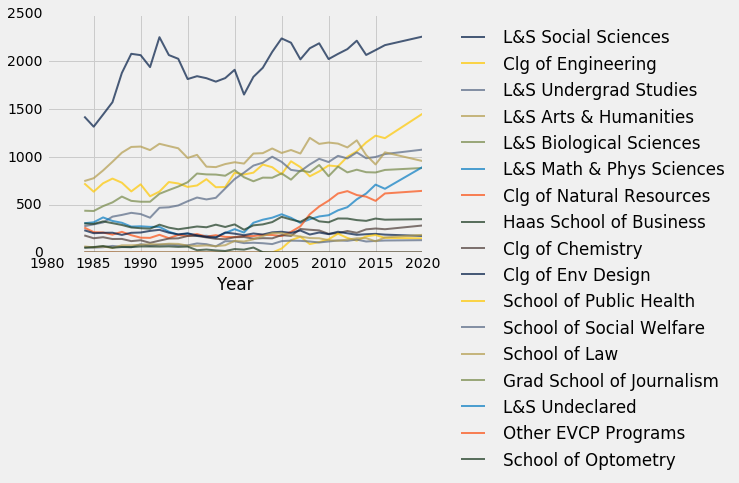

In [74]:
forecast_rdiv_by_year = forecast_table(rdiv_BAs_by_year, 5, 5)
forecast_rdiv_by_year.plot('Year')

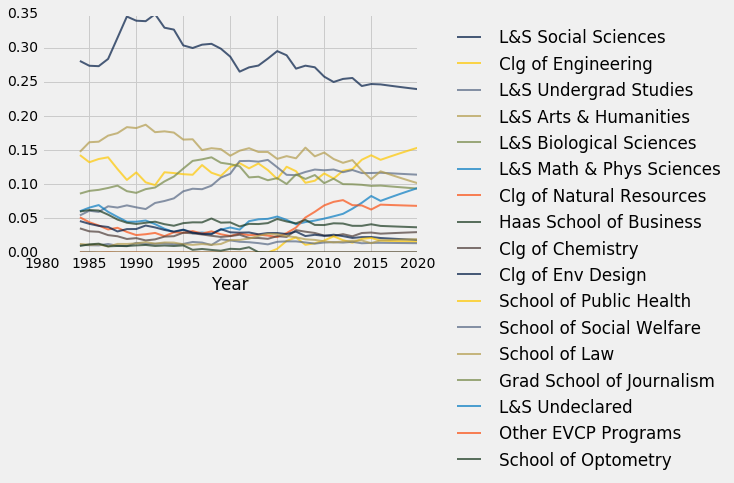

In [75]:
normalize_table(forecast_rdiv_by_year).plot('Year')

<a id="subsection_majors"></a>

### Majors

A total of 143 majors are supported across the divisions.  This metric is both workload and productivity and tends to lead `degrees` as it includes more than the graduating cohort. College differences complicate it, as Engineering students declare as freshman, whereas are `Undeclared` initially in L&S.  This is the largest segment.  

Available for a bit over a decade, the growth of L&S Administered programs is more pronounced, reflecting the growth in computer science.

Reflecting administered programs back to their colleges and schools, College of Engineering is within 80% of Social Sciences, not counting L&S Undeclared in either case.  Clearly, the non-L&S portion of COE load has lower division students attributed as majors.

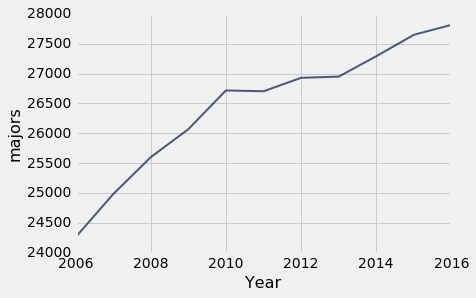

In [76]:
UCB_majors_by_year = majors.select(['Year', 'Majors']).group('Year', collect=sum_collect).relabel('Majors sum_collect', 'majors')
UCB_majors_by_year.plot('Year')

In [77]:
division_majors = majors.select(['Year', 'Division','Majors', 'Students']).groups(['Year', 'Division'], collect=sum_collect)
print(division_majors.num_rows, " majors")
division_majors

143  majors


Year | Division                      | Majors sum_collect | Students sum_collect
2006 | Clg of Chemistry              | 757                | 729.5
2006 | Clg of Engineering            | 2623               | 2513.17
2006 | Clg of Env Design             | 618                | 608.5
2006 | Clg of Natural Resources      | 1078               | 1057
2006 | Haas School of Business       | 591                | 494.333
2006 | L&S Administered Programs     | 1029               | 865.333
2006 | L&S Arts & Humanities         | 2088               | 1802
2006 | L&S Biological Sciences       | 1445               | 1331
2006 | L&S Math & Phys Sciencesences | 603                | 492.833
2006 | L&S Social Sciences           | 4274               | 3684
... (133 rows omitted)

In [78]:
div_majors_by_year = sort_cols(division_majors.pivot('Division', 'Year', 'Majors sum_collect', collect=sum ))
div_students_by_year = sort_cols(division_majors.pivot('Division', 'Year', 'Students sum_collect', collect=sum ))

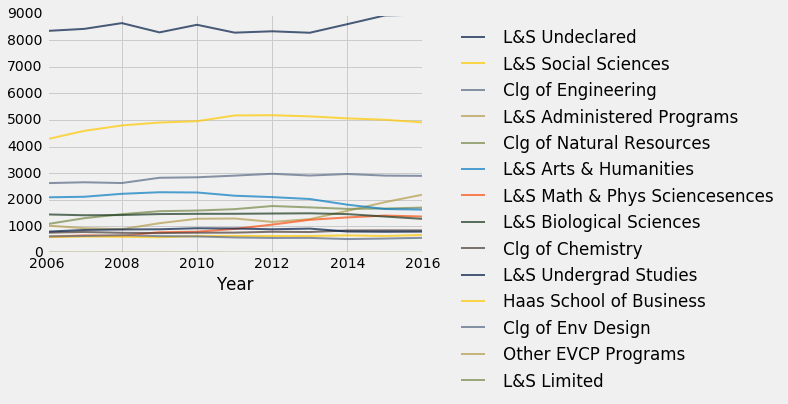

In [79]:
# 10 year trend in majors, uncorrected for L&S Administrative program and including undeclared
div_majors_by_year.plot('Year')

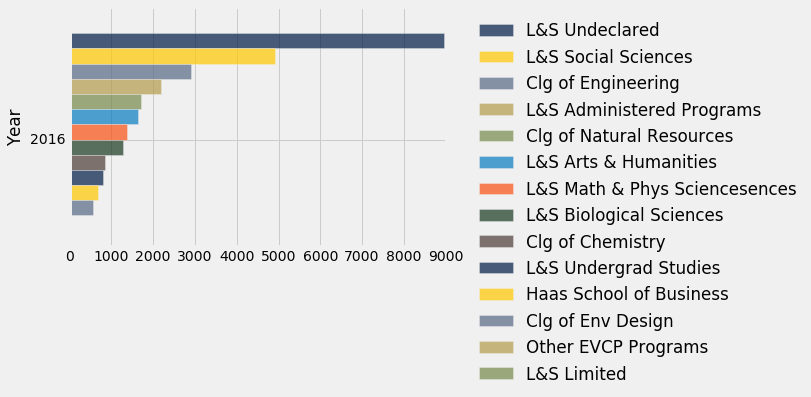

In [80]:
div_majors_by_year.where('Year', 2016).barh('Year')

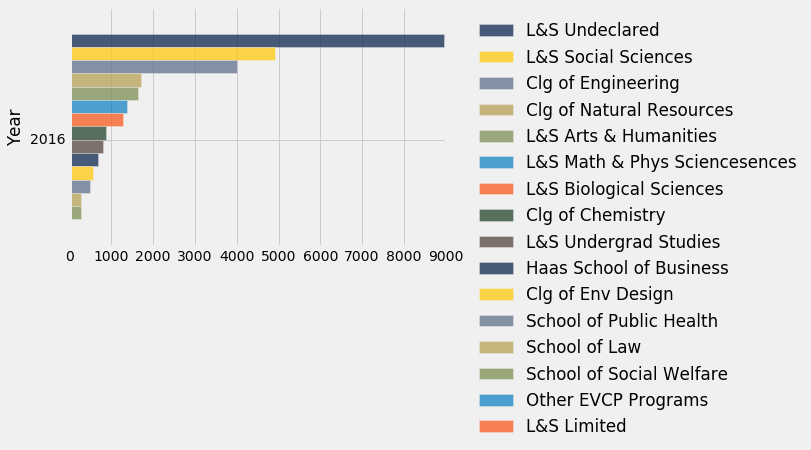

In [81]:
# 10 year trend in majors, with L&S adminstrative programs redistributed to source division
rmajors = majors.with_column('Division', majors.apply(map_div, ['Division', 'Department']))
division_rmajors = rmajors.select(['Year', 'Division','Majors', 'Students']).groups(['Year', 'Division'], collect=sum_collect)
rdiv_majors_by_year = sort_cols(division_rmajors.pivot('Division', 'Year', 'Majors sum_collect', collect=sum ))
rdiv_students_by_year = sort_cols(division_rmajors.pivot('Division', 'Year', 'Students sum_collect', collect=sum ))
rdiv_majors_by_year.where('Year', 2016).barh('Year')

(0, 6000)

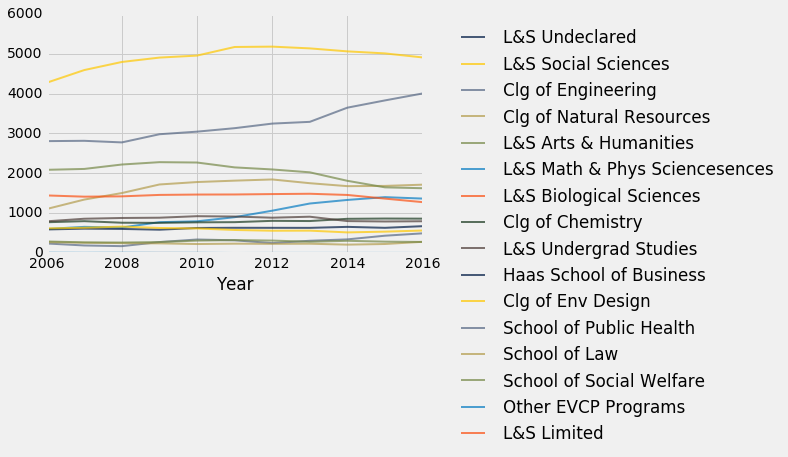

In [82]:
rdiv_majors_by_year.plot('Year')
plots.ylim(0,6000)

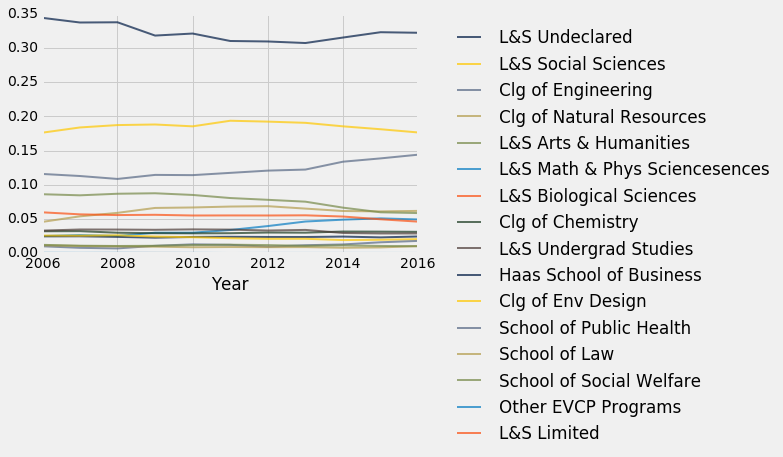

In [83]:
normalize_table(rdiv_majors_by_year).plot('Year')

Forecasting this out 5 years, engineering has as many undergrads as social sciences and MPS is much larger than humanities or biological sciences

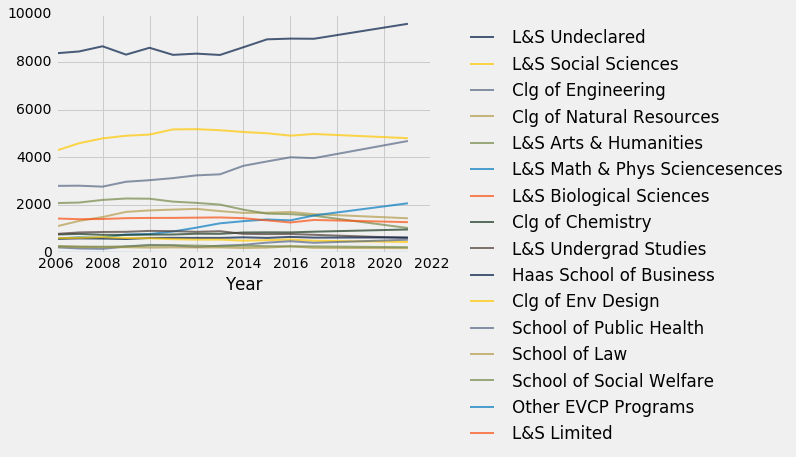

In [84]:
forecast_table(rdiv_majors_by_year, 5, 5).plot('Year')

In [85]:
# Majors by division w/o redistribution of administered programs
sort_cols(div_majors_by_year.where('Year', 2016))

Year | L&S Undeclared | L&S Social Sciences | Clg of Engineering | L&S Administered Programs | Clg of Natural Resources | L&S Arts & Humanities | L&S Math & Phys Sciencesences | L&S Biological Sciences | Clg of Chemistry | L&S Undergrad Studies | Haas School of Business | Clg of Env Design | Other EVCP Programs | L&S Limited
2016 | 8969           | 4909                | 2897               | 2189                      | 1702                     | 1626                  | 1366                          | 1277                    | 844              | 797                   | 673                     | 564               | 1                   | 0

In [86]:
# Majors bny division
sort_cols(rdiv_majors_by_year.where('Year', 2016))

Year | L&S Undeclared | L&S Social Sciences | Clg of Engineering | Clg of Natural Resources | L&S Arts & Humanities | L&S Math & Phys Sciencesences | L&S Biological Sciences | Clg of Chemistry | L&S Undergrad Studies | Haas School of Business | Clg of Env Design | School of Public Health | School of Law | School of Social Welfare | Other EVCP Programs | L&S Limited
2016 | 8969           | 4909                | 4004               | 1715                     | 1626                  | 1366                          | 1277                    | 862              | 797                   | 673                     | 564               | 493                     | 281           | 277                      | 1                   | 0

In [87]:
# Normalized by FTE
sort_cols(norm_col_by_tbl(rdiv_majors_by_year.where('Year', 2016), fte_by_div, 'Division', 'FTE'))

Year | L&S Undeclared | L&S Undergrad Studies | L&S Social Sciences | Clg of Engineering | School of Social Welfare | Clg of Natural Resources | Clg of Chemistry | L&S Biological Sciences | Clg of Env Design | School of Public Health | Haas School of Business | L&S Arts & Humanities | School of Law | Other EVCP Programs
2016 | inf            | 265.667               | 18.2186             | 17.6777            | 17.3125                  | 15.6122                  | 14.735           | 12.0529                 | 10.7429           | 10.5455                 | 8.20732                 | 6.74689               | 4.58776       | 0.153846

In [88]:
scale_cols(sort_cols(norm_col_by_tbl(rdiv_majors_by_year.where('Year', 2016), fte_by_div, 'Division', 'FTE')),1/majors2016_per_fte, 3, True)

L&S Social Sciences | Clg of Engineering | School of Social Welfare | Clg of Natural Resources | Clg of Chemistry | L&S Biological Sciences | Clg of Env Design | School of Public Health | Haas School of Business | L&S Arts & Humanities | School of Law | Other EVCP Programs
1.46005             | 1.4167             | 1.38743                  | 1.25117                  | 1.18088          | 0.965923                | 0.860939          | 0.845119                | 0.657739                | 0.5407                | 0.367666      | 0.0123293

<a id="subsection_credits"></a>

### Enrollment

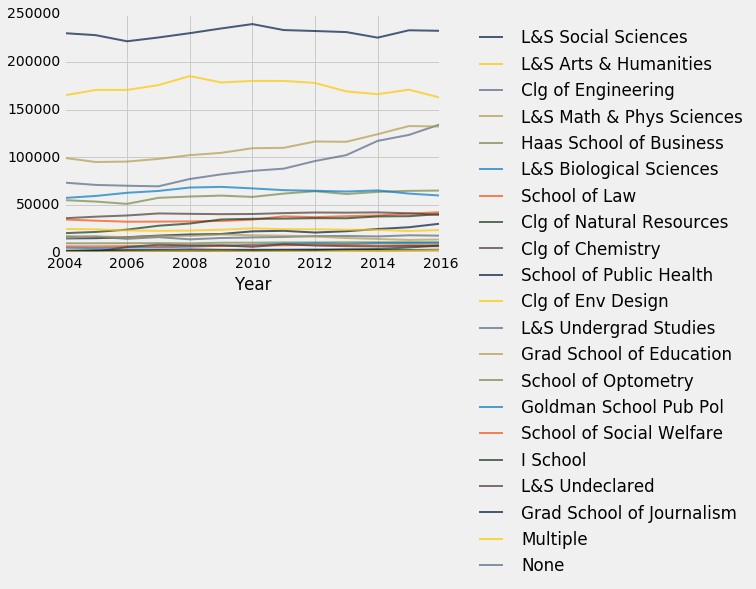

In [89]:
div_credits = courses.join('Subject', subject_map).select(['Division', 'Year', 'Credits']).groups(['Division', 'Year'], collect=sum)
div_credits_by_year = sort_cols(div_credits.pivot('Division', 'Year', 'Credits sum', collect=sum))
div_credits_by_year.plot('Year')

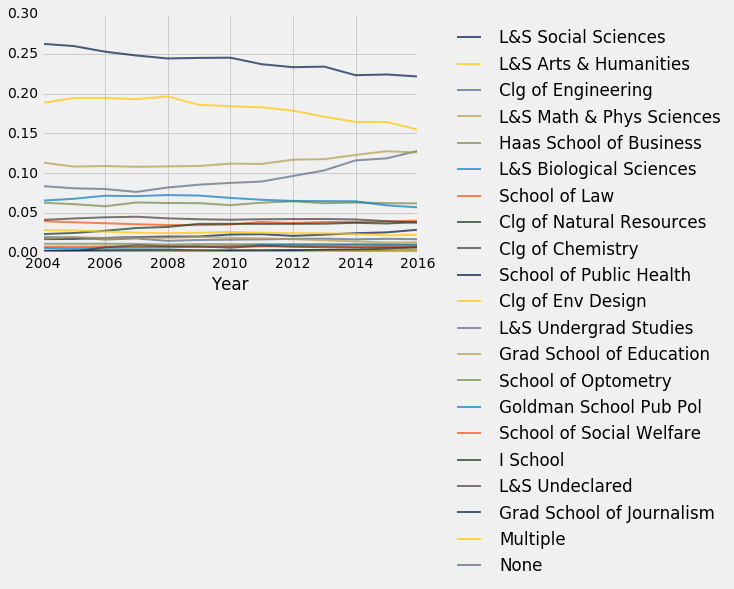

In [90]:
normalize_table(div_credits_by_year).plot('Year')

Forecasting credits out five years, both engineering and MPS are delivering more SCH than Humanities

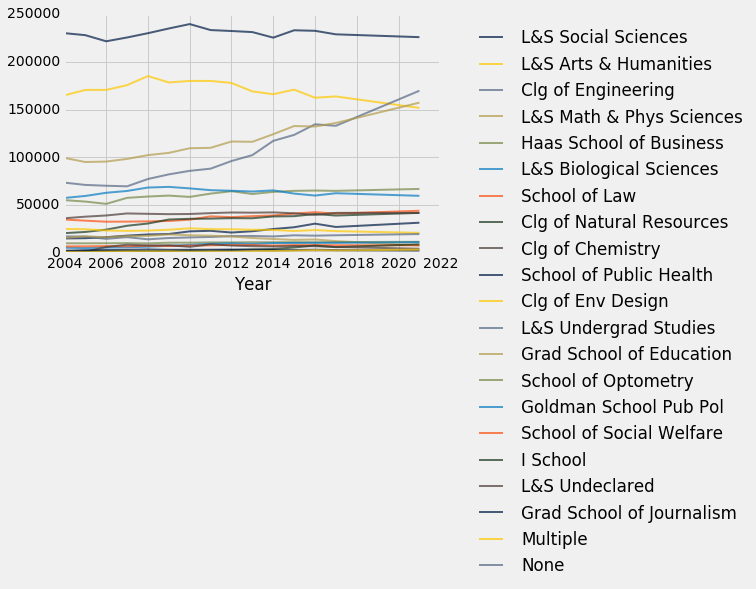

In [91]:
forecast_table(div_credits_by_year, 5, 5).plot('Year')

In [92]:
sort_cols(div_credits_by_year.where('Year', 2016))

Year | L&S Social Sciences | L&S Arts & Humanities | Clg of Engineering | L&S Math & Phys Sciences | Haas School of Business | L&S Biological Sciences | School of Law | Clg of Natural Resources | Clg of Chemistry | School of Public Health | Clg of Env Design | L&S Undergrad Studies | Grad School of Education | School of Optometry | Goldman School Pub Pol | School of Social Welfare | I School | L&S Undeclared | Grad School of Journalism | Multiple | None
2016 | 232378              | 162409                | 134602             | 132299                   | 65312                   | 60074                   | 42720         | 40769.5                  | 39879            | 30688                   | 24038             | 18131                 | 14138                    | 11140               | 10661                  | 8293                     | 7818     | 7107           | 3417.5                    | 2978     | 350

In [93]:
sort_cols(norm_col_by_tbl(div_credits_by_year.where('Year', 2016), fte_by_div, 'Division', 'FTE'))

Year | L&S Undeclared | L&S Undergrad Studies | L&S Math & Phys Sciences | L&S Social Sciences | Haas School of Business | School of Optometry | School of Law | Clg of Chemistry | L&S Arts & Humanities | School of Public Health | I School | Clg of Engineering | Goldman School Pub Pol | L&S Biological Sciences | School of Social Welfare | Grad School of Education | Clg of Env Design | Grad School of Journalism | Clg of Natural Resources
2016 | inf            | 6043.67               | 892.405                  | 862.414             | 796.488                 | 742.667             | 697.469       | 681.692          | 673.896               | 656.428                 | 651.5    | 594.269            | 576.27                 | 567.003                 | 518.312                  | 500.46                   | 457.867           | 379.722                   | 371.138

In [94]:
credits2016_per_fte

688.52474755835112

In [95]:
# Credits per FTE relative to campus average
scale_cols(sort_cols(norm_col_by_tbl(div_credits_by_year.where('Year', 2016), 
                                     fte_by_div, 'Division', 'FTE')), 1/credits2016_per_fte, 3, True)


L&S Math & Phys Sciences | L&S Social Sciences | Haas School of Business | School of Optometry | School of Law | Clg of Chemistry | L&S Arts & Humanities | School of Public Health | I School | Clg of Engineering | Goldman School Pub Pol | L&S Biological Sciences | School of Social Welfare | Grad School of Education | Clg of Env Design | Grad School of Journalism | Clg of Natural Resources
1.29611                  | 1.25255             | 1.1568                  | 1.07863             | 1.01299       | 0.990077         | 0.978754              | 0.953383                | 0.946226 | 0.863105           | 0.836964               | 0.823505                | 0.752787                 | 0.726859                 | 0.664997          | 0.551501                  | 0.539034

<a id="section_engineering"></a>

## Engineering

Engineering's undergraduate role in the university as a whole is now determined primarily by computer science.  While it remains the largest producer of PhDs and among the three large masters programs, its average standing in undergraduate prodctivity and workload is because computer science compensates for far below average rates of all the other programs.

The scale of this effect is obscure by two effects - L&S CS being attributed to the College of Letters and Science and Computer Science being a division with Electrical Engineering and Computer Sciences. 

With L&S administered programs properly attributed to engineering departments (EECS and IEOR) we find that:
* since 2014 EECS grants more bachelors degrees than all the rest of engineering
* since 2014 EECS has more majors than all the rest of engineering
* since 2013 EECS has delivered more SCH than all the rest of engineering, and in 2016 it is nearly twice that of the rest.

Forecasting out five years by each of these metrics, EECS is 2/3rds of the COE.

With separation of EECS into its two divisions, EE and CS we find:
* in 2015 CS grants more bachelors degrees than all the rest of engineering
* in 2016 CS has more majors than all the rest of engineering
* in 2016 CS has delivered more SCH than all the rest of engineering

In [96]:
def div_grad_table_by_year(div, reflow_admin_pgms=False, degrees_tbl = degrees):
    if reflow_admin_pgms:
        degrees_tbl = degrees_tbl.with_column('Division',
                                              degrees_tbl.apply(map_div, ['Division', 'Department']))
    rows = degrees_tbl["Division"] == div
    degrees_sum = degrees.where(rows).select(['Year', 'DegLvlDesc', 'Grads', 'Prorated']).groups(['Year', 'DegLvlDesc'], collect=sum)
    grads_by_year = degrees_sum.pivot('DegLvlDesc', 'Year', 'Grads sum', collect=sum)
    return grads_by_year

In [97]:
def combine_LS(dept):
    if dept == "L&S Computer Science":
        return "Electrical Eng & Computer Sci"
    elif dept == "L&S Ops Research & Mgmt Sci":
        return "Industrial Eng & Ops Research"
    else:
        return dept
    
def div_grads(division, degree_level, reflow_admin_pgms=False, fix_depts = False, degrees_tbl=degrees):
    degrees_tbl = degrees_tbl.copy()
    if reflow_admin_pgms:
        degrees_tbl = degrees_tbl.with_column('Division',
                                              degrees_tbl.apply(map_div, ['Division', 'Department']))
    if fix_depts:
        degrees_tbl['Department'] = degrees_tbl.apply(combine_LS, 'Department')
    div_degrees = degrees_tbl.where('Division', division)
    div_grad = div_degrees.select(['Year', 'DegLvl', 'Department', 'Grads', 'Prorated']).where('DegLvl', degree_level).drop('DegLvl')
    div_grads_by_year = sort_cols(div_grad.pivot('Department', 'Year', 'Grads', collect=sum))
    return div_grads_by_year

def div_majors(division, reflow_admin_pgms=False, fix_depts=False, majors_tbl=rmajors):
    div_majors = majors_tbl.where('Division', division)
    if reflow_admin_pgms:
        div_majors = div_majors.with_column('Department', div_majors.apply(combine_LS, 'Department'))
    if fix_depts:
        div_majors['Department'] = div_majors.apply(combine_LS, 'Department')
    div_majors_by_year = sort_cols(div_majors.pivot('Department', 'Year', 'Majors', collect=sum))
    return div_majors_by_year

def div_credits(division, courses_tbl=courses_by_dept):
    div_courses = courses_tbl.where('Division', division)
    div_courses_by_year = sort_cols(div_courses.drop(['Subject', 'Division']).pivot('Department', 'Year', 'Credits', collect=sum))
    return div_courses_by_year



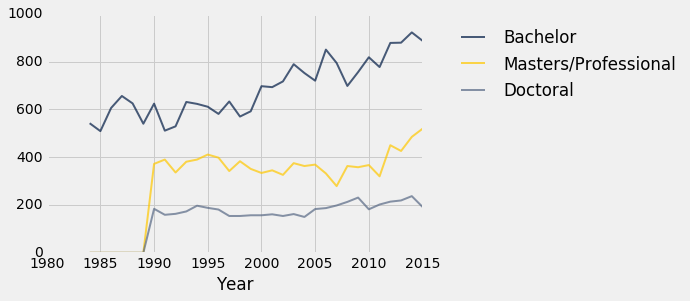

In [98]:
# College degree production w/o attribution of L&S Administered programs
sort_cols(div_grad_table_by_year('Clg of Engineering', False)).plot('Year')

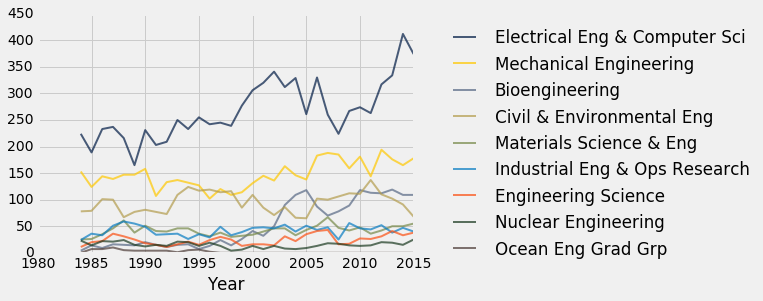

In [99]:
# College of Engineering undergrad degrees by department, w/o administered programs
eng_BAs_by_year = div_grads('Clg of Engineering', 1, False)
eng_BAs_by_year.plot('Year')

### Perspective on CoE when adminstered programs are attributed

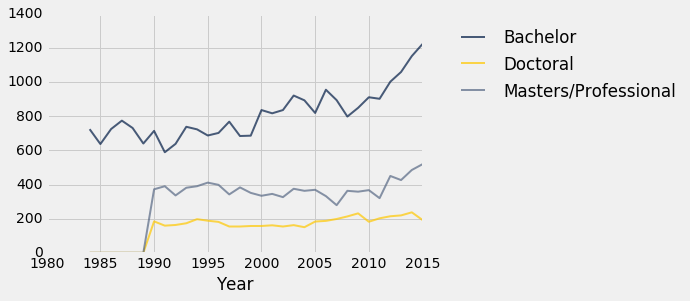

In [100]:
# Dispositions of degrees
div_grad_table_by_year('Clg of Engineering', True).plot('Year')

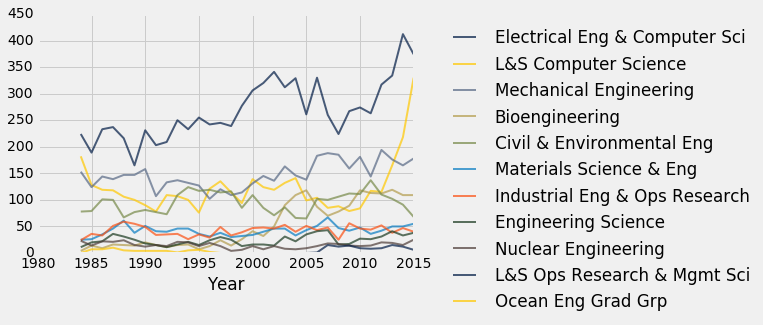

In [101]:
div_grads('Clg of Engineering', 1, True, False).plot('Year')

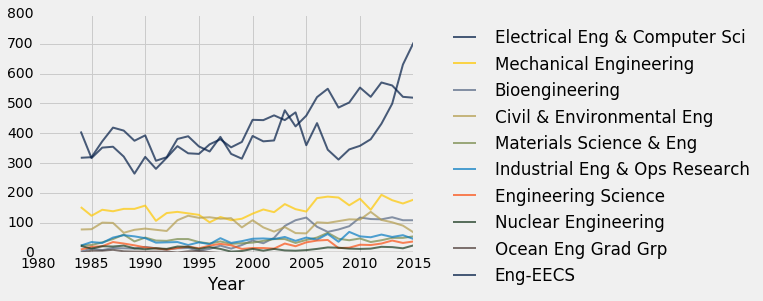

In [102]:
eng_rBAs_by_year = div_grads('Clg of Engineering', 1, True, True)
eng_rBAs_by_year.with_column("Eng-EECS", sum_rows(eng_rBAs_by_year,2)).plot('Year')

In [103]:
eng_rBAs_by_year.where('Year', 2015)

Year | Electrical Eng & Computer Sci | Mechanical Engineering | Bioengineering | Civil & Environmental Eng | Materials Science & Eng | Industrial Eng & Ops Research | Engineering Science | Nuclear Engineering | Ocean Eng Grad Grp
2015 | 704                           | 178                    | 109            | 68                        | 55                      | 46                            | 38                  | 25                  | 0

In [104]:
sort_cols(norm_col_by_tbl(eng_rBAs_by_year.where('Year', 2015), fte_by_dept, 'Department', 'FTE'))

Year | Engineering Science | Electrical Eng & Computer Sci | Bioengineering | Mechanical Engineering | Materials Science & Eng | Industrial Eng & Ops Research | Nuclear Engineering | Civil & Environmental Eng | Ocean Eng Grad Grp
2015 | inf                 | 7.77901                       | 5.58974        | 4.34146                | 4.23077                 | 3.28571                       | 3.125               | 1.67901                   | nan

In [105]:
BAs2015_per_fte

5.6818407548419119

In [106]:
scale_cols(sort_cols(norm_col_by_tbl(eng_rBAs_by_year.where('Year', 2015), fte_by_dept, 'Department', 'FTE')),1/BAs2015_per_fte,2, True)

Electrical Eng & Computer Sci | Bioengineering | Mechanical Engineering | Materials Science & Eng | Industrial Eng & Ops Research | Nuclear Engineering | Civil & Environmental Eng | Ocean Eng Grad Grp
1.3691                        | 0.983791       | 0.764095               | 0.744612                | 0.578283                      | 0.549998            | 0.295505                  | nan

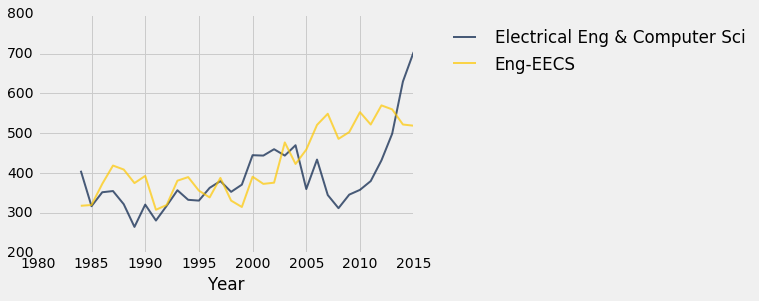

In [107]:
eng_rBAs_by_year.select(['Year', 'Electrical Eng & Computer Sci']).with_column('Eng-EECS', sum_rows(eng_rBAs_by_year,2)).plot('Year')

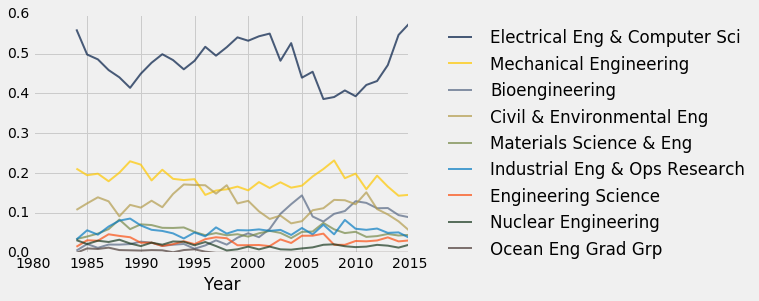

In [108]:
normalize_table(eng_rBAs_by_year).plot('Year')

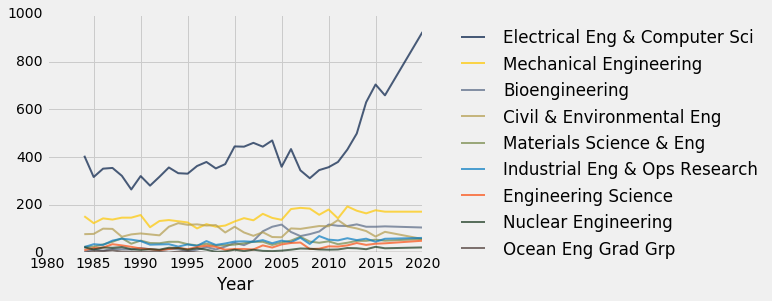

In [109]:
forecast_table(eng_rBAs_by_year, 5, 5).plot('Year')

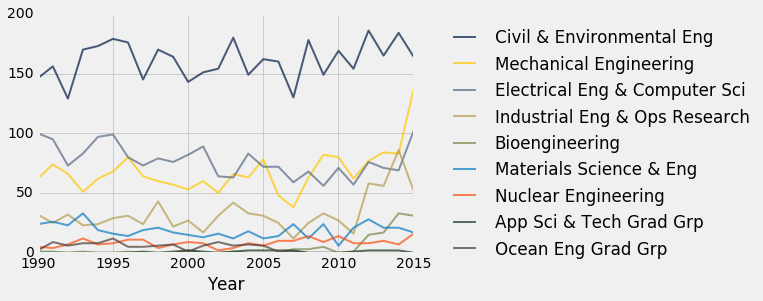

In [110]:
# Masters
eng_MSs_by_year = div_grads('Clg of Engineering', 2)
eng_MSs_by_year.plot('Year')

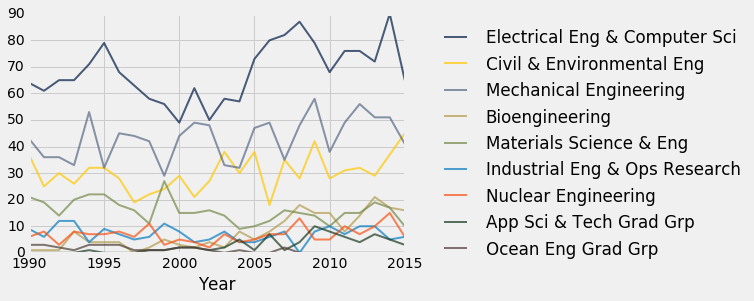

In [111]:
# PhDs
eng_PhDs_by_year = div_grads('Clg of Engineering', 3)
eng_PhDs_by_year.plot('Year')

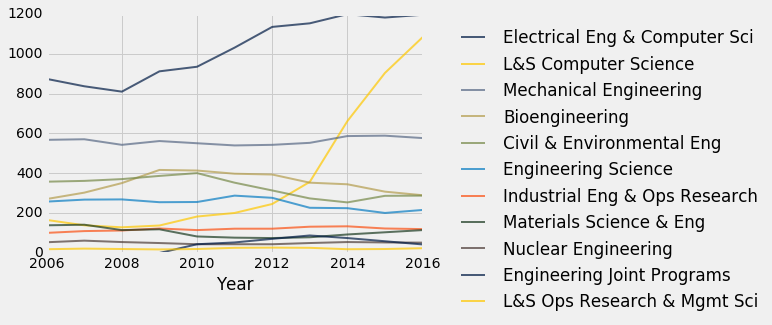

In [112]:
# Undergraduate Engineering Majors by program
div_majors('Clg of Engineering').plot('Year')

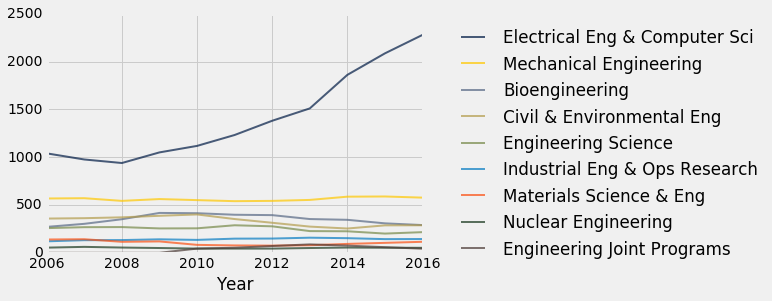

In [113]:
# Undergrad majors by department, including L&S adminstered programs
eng_rmajors_by_year = div_majors('Clg of Engineering', True, True)
eng_rmajors_by_year.plot('Year')

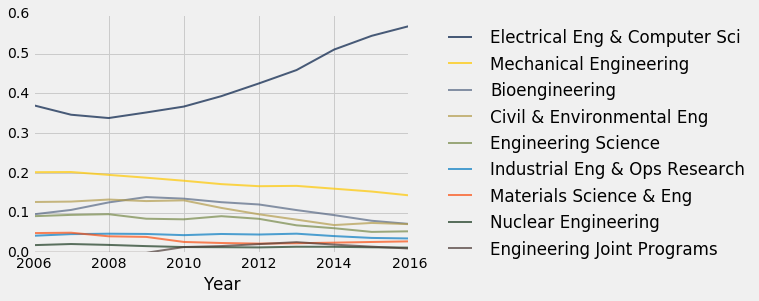

In [114]:
normalize_table(eng_rmajors_by_year).plot('Year')

Forcasting this out, we might expect 3,000 EECS majors by 2020.

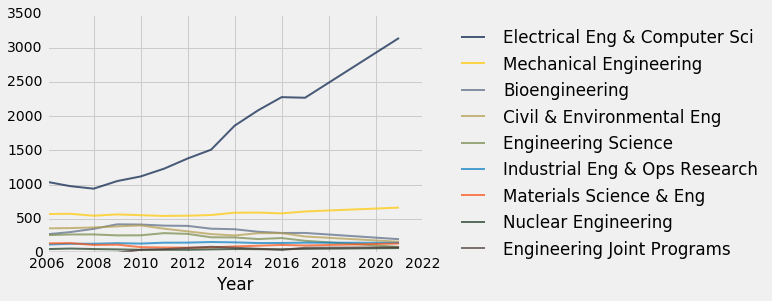

In [115]:
forecast_table(eng_rmajors_by_year, 5, 5).plot('Year')

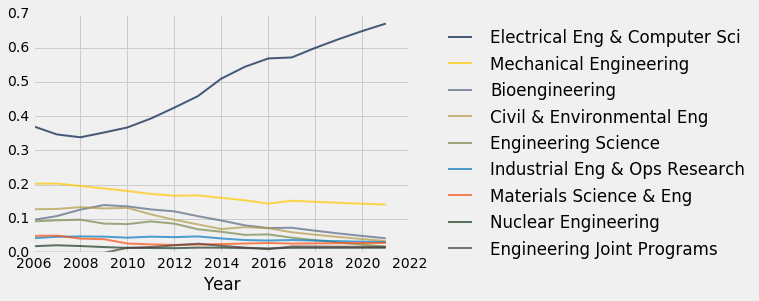

In [116]:
normalize_table(forecast_table(eng_rmajors_by_year, 5, 5)).plot('Year')

Current per FTE comparison

In [117]:
scale_cols(sort_cols(norm_col_by_tbl(eng_rmajors_by_year.where('Year', 2016), fte_by_dept, 'Department', 'FTE')),1/majors2016_per_fte,2, True)

Electrical Eng & Computer Sci | Bioengineering | Mechanical Engineering | Industrial Eng & Ops Research | Materials Science & Eng | Civil & Environmental Eng | Nuclear Engineering
2.01813                       | 1.19183        | 1.12783                | 0.824304                      | 0.708936                | 0.569889                  | 0.520914

In [118]:
eng_rmajors_by_year

Year | Electrical Eng & Computer Sci | Mechanical Engineering | Bioengineering | Civil & Environmental Eng | Engineering Science | Industrial Eng & Ops Research | Materials Science & Eng | Nuclear Engineering | Engineering Joint Programs
2006 | 1040                          | 568                    | 271            | 358                       | 258                 | 120                           | 139                     | 54                  | 0
2007 | 976                           | 571                    | 303            | 362                       | 268                 | 132                           | 142                     | 62                  | 0
2008 | 939                           | 543                    | 351            | 371                       | 269                 | 133                           | 115                     | 55                  | 0
2009 | 1050                          | 562                    | 417            | 387                       | 255                 | 141                           | 119                     | 50                  | 0
2010 | 1118                          | 551                    | 414            | 401                       | 256                 | 135                           | 83                      | 44                  | 44
2011 | 1232                          | 540                    | 398            | 353                       | 288                 | 148                           | 77                      | 44                  | 53
2012 | 1381                          | 543                    | 394            | 314                       | 277                 | 149                           | 75                      | 44                  | 71
2013 | 1510                          | 553                    | 353            | 274                       | 227                 | 158                           | 79                      | 50                  | 88
2014 | 1861                          | 587                    | 345            | 254                       | 225                 | 153                           | 93                      | 55                  | 75
2015 | 2086                          | 589                    | 308            | 287                       | 201                 | 143                           | 104                     | 53                  | 59
... (1 rows omitted)

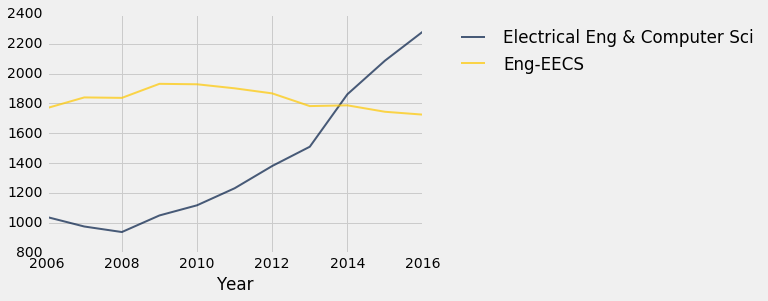

In [119]:
eng_rmajors_by_year.select(['Year', 'Electrical Eng & Computer Sci']).with_column('Eng-EECS', sum_rows(eng_rmajors_by_year,2)).plot('Year')

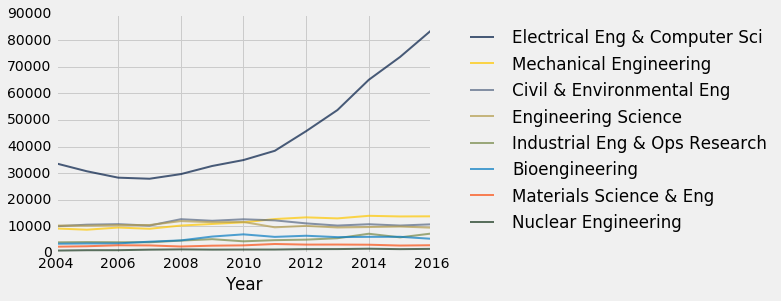

In [120]:
# Student credits
eng_courses_by_year = div_credits('Clg of Engineering')
eng_courses_by_year.plot('Year')

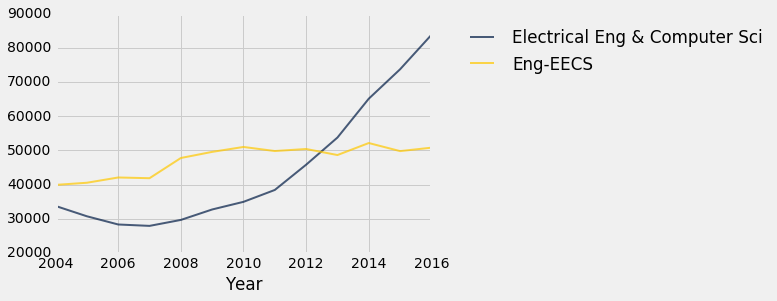

In [121]:
eng_courses_by_year.select(['Year', 'Electrical Eng & Computer Sci']).with_column('Eng-EECS', sum_rows(eng_courses_by_year,2)).plot('Year')

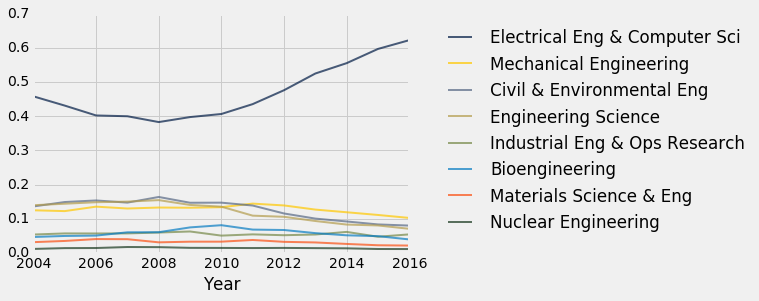

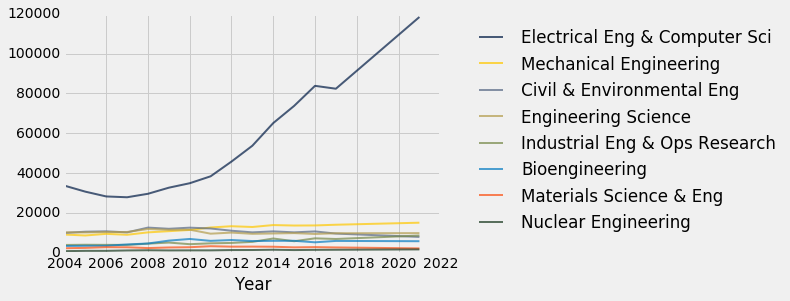

In [122]:
normalize_table(eng_courses_by_year).plot('Year')
forecast_table(eng_courses_by_year, 5, 5).plot('Year')

In [123]:
credits2016_per_fte

688.52474755835112

In [124]:
# Student credit hours per FTE relative to campus average
scale_cols(sort_cols(norm_col_by_tbl(eng_courses_by_year.where('Year', 2016), fte_by_dept, 'Department', 'FTE')),1/credits2016_per_fte,2, True)

Electrical Eng & Computer Sci | Industrial Eng & Ops Research | Mechanical Engineering | Bioengineering | Civil & Environmental Eng | Materials Science & Eng | Nuclear Engineering
1.34511                       | 0.753059                      | 0.486689               | 0.392441       | 0.384755                  | 0.31863                 | 0.268509

<a id="section_eecs"></a>

## Separating divisions within EECS in college picture

In order to estimate of production rate of EE and CS within EECS, we need to utilize other data sources, either the graduation exit survey or the concentration data within the major.  From 2012 on we have a relatively simple articulation of ECE, CSE and EECS.  Prior to that we have the five options electronics, communications, computer systems, computer science and general.  The with changing demographics, the concentration data leads production changes, because it incorporates new cohorts, but it also dampens the swing because it averages over all cohorts.

As an example, the Spring 2013 exit survey shows:
* EE	17.5%
* CS	63.4%
* EECS	19.9%
* unknown	2.3%

The 12-13 concentration data shows:
* EE 28.7%
* CS 61.6%
* EECS 4.4%
* Other 5.3%

These data are useful in allowing comparison to trends at other leading institutions. Here we build a rough model, distributing the EECS pool across EE and CS on a pro rata basis in order to have a common basis for national comparisons and to gain some insight into divisional characteristics.


In [125]:
EECS_concentrations = Table(['Year', 'CSE', 'ECE', 'EECS', 'other']).with_rows(
    [('2012', 699, 418, 183, 75),
    ('2013', 892, 415, 64, 77),
    ('2014', 950, 259, 121, 54),
    ('2015', 922, 218, 174, 54),
    ('2016', 820, 191, 293, 37)
    ]
)

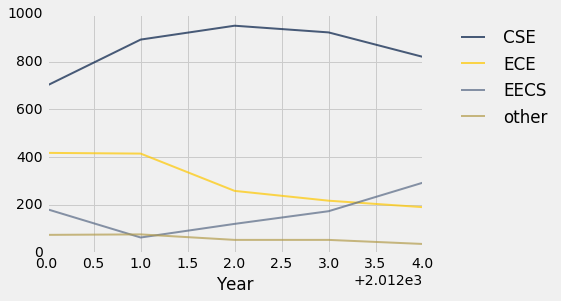

In [126]:
EECS_concentrations.plot('Year')

In [127]:
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline([1984, 1990, 2002, 2006, 2007, 2012, 2013, 2014, 2015],
                       [0.45, 0.5, 0.65, 0.5, 0.5, 0.63, 0.68, 0.79, 0.81])

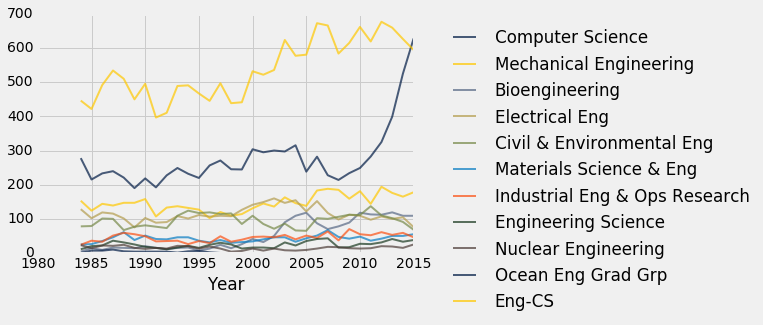

In [128]:
# Undergraduate engineering degrees by program
adj_eng_degrees = revised_degrees.where('Division', 'Clg of Engineering').where('DegLvl', 1)
adj_eng_degrees_by_year = adj_eng_degrees.pivot('Department', 'Year', 'Grads', collect=sum)
cs_d_fraction = spl(adj_eng_degrees_by_year['Year'])
adj_eng_degrees_by_year['Computer Science'] = cs_d_fraction*adj_eng_degrees_by_year['Electrical Eng & Computer Sci'] + adj_eng_degrees_by_year['L&S Computer Science']
adj_eng_degrees_by_year['Electrical Eng'] = (1-cs_d_fraction)*adj_eng_degrees_by_year['Electrical Eng & Computer Sci']
adj_eng_degrees_by_year['Industrial Eng & Ops Research'] = adj_eng_degrees_by_year['Industrial Eng & Ops Research']+adj_eng_degrees_by_year['L&S Ops Research & Mgmt Sci']
adj_eng_degrees_by_year = sort_cols(adj_eng_degrees_by_year.drop(['Electrical Eng & Computer Sci', 'L&S Computer Science', 'L&S Ops Research & Mgmt Sci']))
adj_eng_degrees_by_year.with_column('Eng-CS', sum_rows(adj_eng_degrees_by_year, 2)).plot('Year')

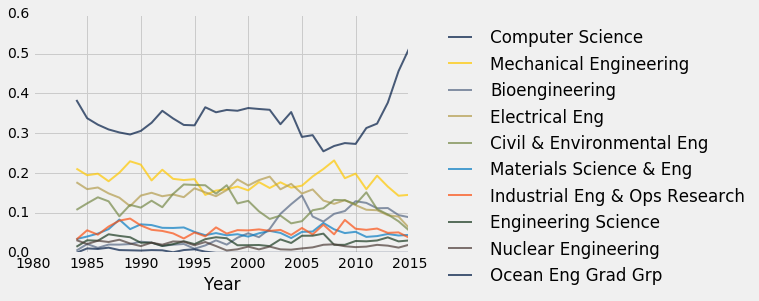

In [129]:
normalize_table(adj_eng_degrees_by_year).plot('Year')

Forecasting this out linearly is toouch because the last several years are curved so heavily upward.  Taking a linear extrapolation over a shorter past window, we can anticipate a thousand graduates per year by 2020.

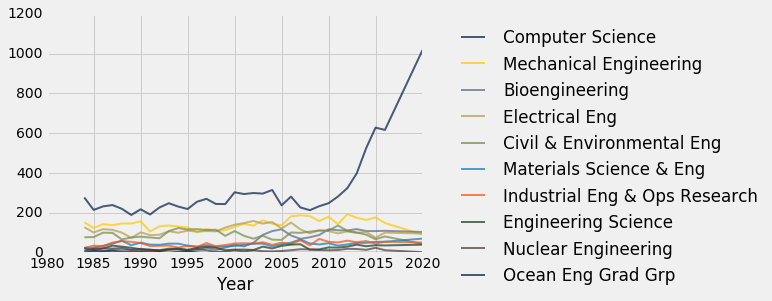

In [130]:
forecast_table(adj_eng_degrees_by_year, 3, 5).plot('Year')

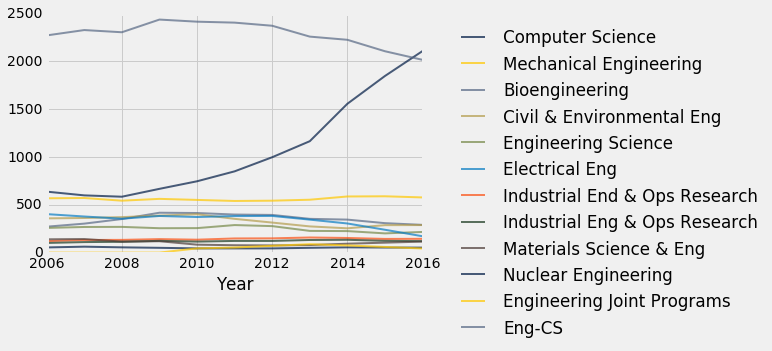

In [131]:
# Undergraduate Majors by program
adj_eng_majors = rmajors.where('Division', 'Clg of Engineering')
adj_eng_majors_by_year = adj_eng_majors.pivot('Department', 'Year', 'Majors', collect=sum)
cs_fraction = spl(adj_eng_majors_by_year['Year'])
adj_eng_majors_by_year['Computer Science'] = adj_eng_majors_by_year['Electrical Eng & Computer Sci']*cs_fraction + adj_eng_majors_by_year['L&S Computer Science']
adj_eng_majors_by_year['Electrical Eng'] = adj_eng_majors_by_year['Electrical Eng & Computer Sci']*(1-cs_fraction)
adj_eng_majors_by_year['Industrial End & Ops Research'] = adj_eng_majors_by_year['Industrial Eng & Ops Research']+adj_eng_majors_by_year['L&S Ops Research & Mgmt Sci']
adj_eng_majors_by_year = sort_cols(adj_eng_majors_by_year.drop(['Electrical Eng & Computer Sci', 'L&S Computer Science', 'L&S Ops Research & Mgmt Sci']))
# Add comparison to engineering sans CS
adj_eng_majors_by_year.with_column('Eng-CS', sum_rows(adj_eng_majors_by_year, 2)).plot('Year')

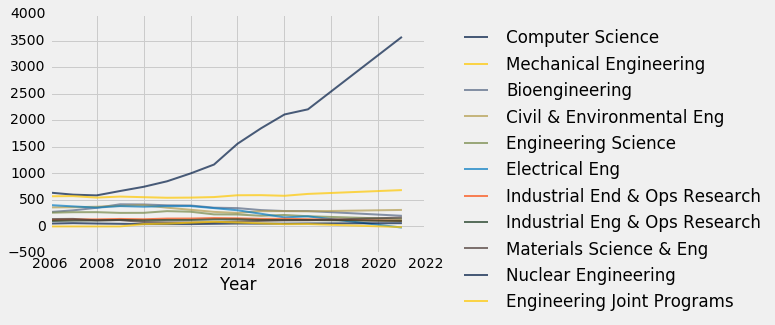

In [132]:
forecast_table(adj_eng_majors_by_year, 3, 5).plot('Year')

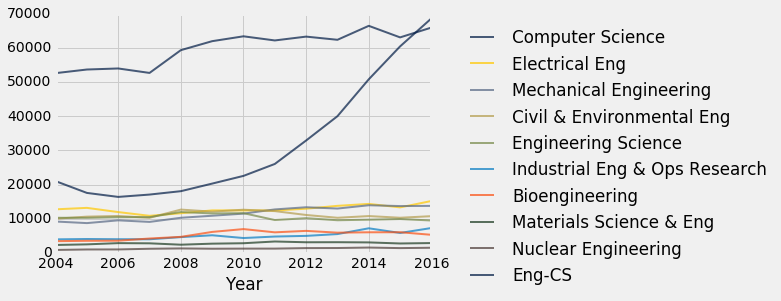

In [133]:
eng_credits = courses.join('Subject', subject_map).where('Division', 'Clg of Engineering')
def split_sub(sub, dept):
    if sub == 'Computer Science':
        return 'Computer Science'
    if sub == 'Electrical Engineering':
        return 'Electrical Eng'
    if sub == 'Electrical Eng & Comp Sci':
        return 'Electrical Eng'
    return dept
eng_credits['Department'] = eng_credits.apply(split_sub, ['Subject', 'Department'])
eng_credits = eng_credits.drop(['Dept', 'Division', 'Subject']) # .groups(['Year', 'Department'], collect=sum)
eng_credits_by_year = sort_cols(eng_credits.pivot('Department', 'Year', 'Credits', collect=sum))
eng_credits_by_year.with_column('Eng-CS', sum_rows(eng_credits_by_year, 2)).plot('Year')


Forecasting this out only five years, the situation relative to the rest of engineering is wild.

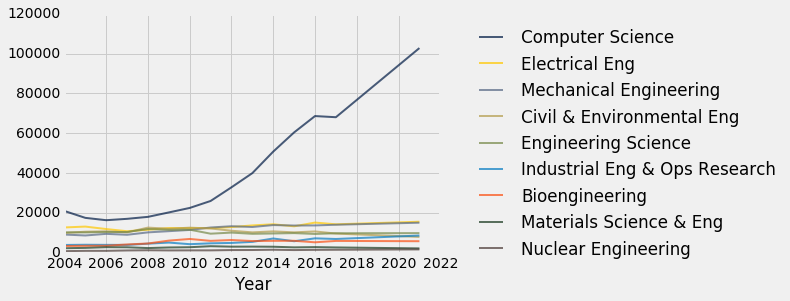

In [134]:
forecast_table(eng_credits_by_year, 5, 5).plot('Year')

In [135]:
EECS_fte = fte_by_dept.where('Department', 'Electrical Eng & Computer Sci')['FTE'][0]
EE_fte = 43.5
CS_fte = EECS_fte-EE_fte
adj_fte_by_dept = fte_by_dept.where(fte_by_dept['Department'] != 'Electrical Eng & Computer Sci' ).with_rows([
        ('Electrical Eng', EE_fte, 'Clg of Engineering'),
        ('Computer Science', CS_fte, 'Clg of Engineering')
    ])
adj_fte_by_dept

Department               | FTE   | Division
Business                 | 82    | Haas School of Business
Molecular & Cell Biology | 72.7  | L&S Biological Sciences
Law                      | 61.25 | School of Law
English                  | 55.25 | L&S Arts & Humanities
Mathematics              | 49.75 | L&S Math & Phys Sciences
Physics                  | 49.25 | L&S Math & Phys Sciences
Env Sci, Policy, & Mgmt  | 49.17 | Clg of Natural Resources
History                  | 47    | L&S Social Sciences
Public Health            | 46.75 | School of Public Health
Chemistry                | 42    | Clg of Chemistry
... (106 rows omitted)

In [136]:
adj_eng_degrees_by_year.where('Year', 2015)

Year | Computer Science | Mechanical Engineering | Bioengineering | Electrical Eng | Civil & Environmental Eng | Materials Science & Eng | Industrial Eng & Ops Research | Engineering Science | Nuclear Engineering | Ocean Eng Grad Grp
2015 | 628.408          | 178                    | 109            | 75.5917        | 68                        | 55                      | 46                            | 38                  | 25                  | 0

In [137]:
scale_cols(sort_cols(norm_col_by_tbl(adj_eng_degrees_by_year.where('Year', 2015), adj_fte_by_dept, 'Department', 'FTE')),1/BAs2015_per_fte, 2, True)

Computer Science | Bioengineering | Mechanical Engineering | Materials Science & Eng | Industrial Eng & Ops Research | Nuclear Engineering | Electrical Eng | Civil & Environmental Eng | Ocean Eng Grad Grp
2.35318          | 0.983791       | 0.764095               | 0.744612                | 0.578283                      | 0.549998            | 0.305841       | 0.295505                  | nan

In [138]:
adj_eng_majors_by_year.where('Year', 2016)

Year | Computer Science | Mechanical Engineering | Bioengineering | Civil & Environmental Eng | Engineering Science | Electrical Eng | Industrial End & Ops Research | Industrial Eng & Ops Research | Materials Science & Eng | Nuclear Engineering | Engineering Joint Programs
2016 | 2107.99          | 577                    | 290            | 288                       | 216                 | 171.006        | 144                           | 120                           | 115                     | 52                  | 43

In [139]:
scale_cols(sort_cols(norm_col_by_tbl(adj_eng_majors_by_year.where('Year', 2016), adj_fte_by_dept, 'Department', 'FTE')),1/majors2016_per_fte, 2, True)

Computer Science | Bioengineering | Mechanical Engineering | Materials Science & Eng | Industrial Eng & Ops Research | Civil & Environmental Eng | Nuclear Engineering | Electrical Eng
3.59438          | 1.19183        | 1.12783                | 0.708936                | 0.68692                       | 0.569889                  | 0.520914            | 0.315047

In [140]:
eng_credits_by_year.where('Year', 2016)

Year | Computer Science | Electrical Eng | Mechanical Engineering | Civil & Environmental Eng | Engineering Science | Industrial Eng & Ops Research | Bioengineering | Materials Science & Eng | Nuclear Engineering
2016 | 68644            | 15172          | 13739                  | 10729                     | 9459                | 7259                          | 5269           | 2852                    | 1479

In [141]:
scale_cols(sort_cols(norm_col_by_tbl(eng_credits_by_year.where('Year', 2016), adj_fte_by_dept, 'Department', 'FTE')),1/credits2016_per_fte, 2, True)

Computer Science | Industrial Eng & Ops Research | Electrical Eng | Mechanical Engineering | Bioengineering | Civil & Environmental Eng | Materials Science & Eng | Nuclear Engineering
2.12122          | 0.753059                      | 0.506564       | 0.486689               | 0.392441       | 0.384755                  | 0.31863                 | 0.268509

<a id="section_eecsdegrees"></a>

## Degrees from EECS

Degrees granted provides a clear sense of the flow of students, while counts of majors and credits reflect workload.

* The rate of degree production from EECS is constant for PhDs at about 70 PhDs/year.
* The masters rate has returned to its historical high of about a hundred, with the introduction of the MEng and expansion of the 5th year MS
* The EECS major has grown, but is constrained by COE admissions.  Presumably, both in the 2000's phase and in the recent one, admission was expanded to maintain some degree of quality balance with the rest of the college.
* The L&S program, which as declarations in place to try to match the EECS admissions threshold, has expanded in an unprecedented fashion.  
* In combination, the prior peak graduation rate was 470 in 2004. It dropped 34% to 312 in 2008. Climbed 2.26x to 704 in 2015-16. 

In [142]:
def grad_table_by_year(depts):
    if type(depts) is str:
        rows = degrees["Department"] == depts
    else:
        rows = degrees["Department"] == depts[0]
        for dept in depts[1:]:
            rows = np.logical_or(rows, degrees["Department"] == dept)
    degrees_sum = degrees.where(rows).select(['Year', 'DegLvlDesc', 'Grads', 'Prorated']).groups(['Year', 'DegLvlDesc'], collect=sum)
    Grads_by_year = degrees_sum.pivot('DegLvlDesc', 'Year', 'Grads sum', collect=sum)
    return Grads_by_year

In [143]:
EECS_grads_by_year = grad_table_by_year(['Electrical Eng & Computer Sci'])
LSCS_grads_by_year = grad_table_by_year(['L&S Computer Science'])
EECS_grads_by_year['LS CS BA'] = LSCS_grads_by_year['Bachelor']
EECS_grads_by_year.relabel('Bachelor', 'EECS BS')
EECS_grads_by_year['Bachelor'] = EECS_grads_by_year['EECS BS'] + EECS_grads_by_year['LS CS BA']
#EECS_grads_by_year.show() #uncomment to see data

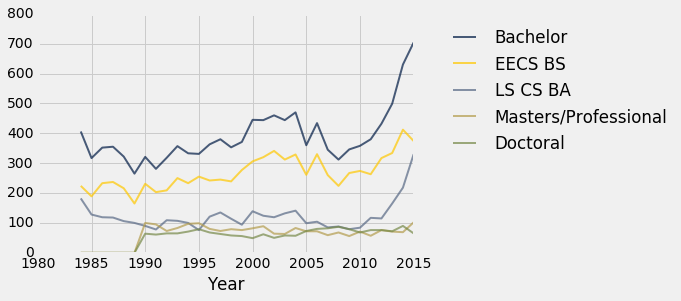

In [144]:
sort_cols(EECS_grads_by_year).plot('Year')

In [145]:
EECS_grads_by_year.where('Doctoral').stats(ops=[min,np.mean,np.std,max])

statistic | Year   | Bachelor | EECS BS | LS CS BA | Masters/Professional | Doctoral
min       | 1990   | 281      | 203     | 76       | 56                   | 49
mean      | 2002.5 | 402.731  | 281.077 | 121.654  | 77.2692              | 68.2308
std       | 7.5    | 94.4606  | 51.2505 | 51.443   | 13.0754              | 10.5732
max       | 2015   | 704      | 412     | 330      | 102                  | 90

In [146]:
max(EECS_grads_by_year['Bachelor'])/min(EECS_grads_by_year['Bachelor'][-10:])

2.2564102564102564

<a id="section_dept"></a>

# Departmental level trends


In [147]:
def grads_by_year(degree_level=1, fix_depts = True, degrees_tbl=degrees):
    degrees_tbl = degrees_tbl.copy()
    if fix_depts:
        degrees_tbl['Department'] = degrees_tbl.apply(combine_LS, 'Department')
    dept_grads = degrees_tbl.where('DegLvl', degree_level).select(['Year', 'Department', 'Grads'])
    dept_grads_by_year = sort_cols(dept_grads.pivot('Department', 'Year', 'Grads', collect=sum))
    return dept_grads_by_year

def majors_by_year(fix_depts=True, majors_tbl=rmajors):
    if fix_depts:
        majors_tbl = majors_tbl.with_column('Department', majors_tbl.apply(combine_LS, 'Department'))
    dept_majors_by_year = sort_cols(majors_tbl.pivot('Department', 'Year', 'Majors', collect=sum))
    return dept_majors_by_year

def credits_by_year(courses_tbl=courses_by_dept):
    dept_courses_by_year = sort_cols(courses_tbl.drop(['Subject', 'Division']).pivot('Department', 'Year', 'Credits', collect=sum))
    return dept_courses_by_year

Amongst very large majors, the recent tripling of computer science is completely unlike all other developments.  Combining it with the near doubling of EECS the landscape has substantially shifted. Economics has also experienced substantial growth, suggesting that there must be substantial decreases in the many smaller programs in ths social sciences.

In [148]:
BAs_by_year = grads_by_year()
BAs_by_year.where('Year', 2015)

Year | Electrical Eng & Computer Sci | Economics | UGIS-UG Interdisc Studies | Molecular & Cell Biology | Integrative Biology | IAS Teaching Program | Psychology | Political Science | Business | Mathematics | English | Env Sci, Policy, & Mgmt | Sociology | Statistics | L&S Public Health | Mechanical Engineering | History | Architecture | Chemistry | L&S Social Welfare | Chem & Biomolecular Eng | L&S Legal Studies | Anthropology | Nutritional Science & Tox | Ag & Resource Econ & Pol | Bioengineering | Physics | Earth & Planetary Science | Philosophy | Rhetoric | Linguistics | Civil & Environmental Eng | Art Practice | Ethnic Studies | History of Art | Film and Media | Materials Science & Eng | Theater Dance & Perf Stds | Plant & Microbial Biology | Geography | Industrial Eng & Ops Research | City & Regional Planning | Spanish & Portuguese | Engineering Science | Music | East Asian Lang & Culture | French | Nuclear Engineering | Classics | Astronomy | Gender & Womens Studies | German | Comparative Literature | L&S Envir Econ & Policy | Near Eastern Studies | Landscape Arch & Env Plan | South & SE Asian Studies | African American Studies | Slavic Languages & Lit | Italian Studies | L&S Chemistry | Other Env Design Programs | Scandinavian | Journalism | L&S Undeclared | Ocean Eng Grad Grp | Optometry | Other Arts & Humanities | Other Bio Sciences Pgms | Other CNR Programs | Other Chemistry Programs | Other EVCP Programs | Other Phys Sci Programs | Other Social Sciences | Physical Education | Wood Sci & Tech Grad Grp
2015 | 704                           | 631       | 593                       | 422                      | 416                 | 407                  | 389        | 370               | 356      | 280         | 277     | 254                     | 247       | 235        | 184               | 178                    | 152     | 135          | 127       | 122                | 121                     | 118               | 116          | 111                       | 110                      | 109            | 94      | 82                        | 81         | 80       | 71          | 68                        | 66           | 66             | 63             | 56             | 55                      | 53                        | 49                        | 47        | 46                            | 45                       | 45                   | 38                  | 38    | 31                        | 31     | 25                  | 23       | 20        | 20                      | 20     | 17                     | 17                      | 15                   | 12                        | 12                       | 9                        | 6                      | 4               | 4             | 4                         | 4            | 0          | 0              | 0                  | 0         | 0                       | 0                       | 0                  | 0                        | 0                   | 0                       | 0                     | 0                  | 0

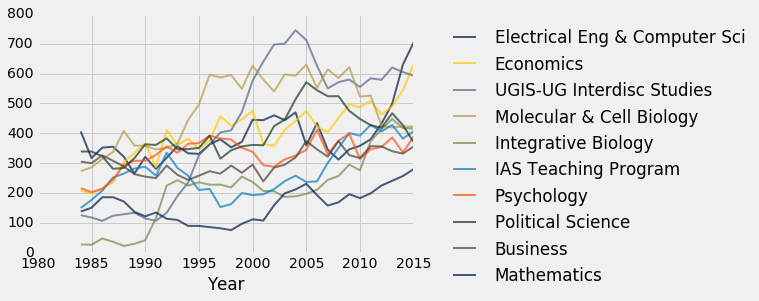

In [149]:
# Graduation rates among the 10 largest programs
top(BAs_by_year, 10).plot('Year')

Looking deeper down, we see the growth in statistics along side computer science, along with a more regular growth in math, but also the large fall off in english and sociology. 

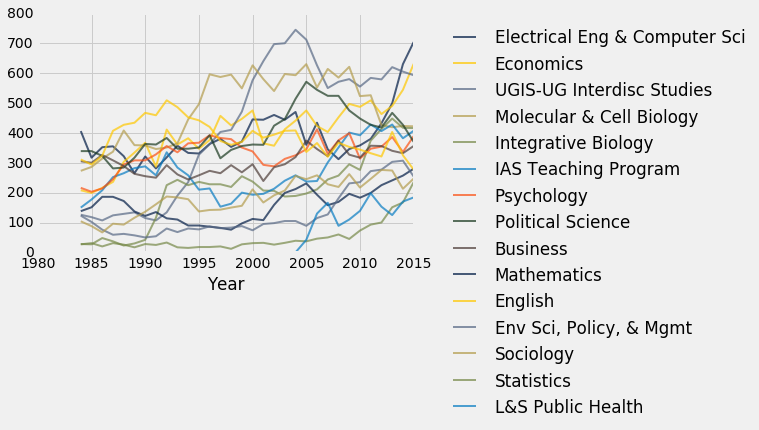

In [150]:
# Looking a little further down presents a rather different picture
top(BAs_by_year, 15).plot('Year')

In [151]:
def convert_by_year_to_change(by_year_tbl, col_type, nyears, add_tbl=None):
    """Convert a table of things_by_year to one of discrete change nyears before end for each thing"""
    last = str(by_year_tbl['Year'][-1])
    prior = str(by_year_tbl['Year'][-nyears-1])
    labels = by_year_tbl.labels[1:]
    by_things_data = [(label, by_year_tbl[label][-nyears-1], by_year_tbl[label][-1]) 
                      for label in labels if by_year_tbl[label][-nyears-1] ]

    changes = Table([col_type, prior, last]).with_rows(by_things_data)
    norm_factor = sum(changes[last])/sum(changes[prior])
# Add entries that are not used in normalization
    if add_tbl:
        for label in add_tbl.labels[1:]:
            changes = changes.with_row([label, add_tbl[label][-nyears-1],add_tbl[label][-1]])
    changes['Growth'] = changes[last]-changes[prior]
    changes['Rel Growth'] = changes[last]/changes[prior]
    changes['Normed ' + prior] = changes[prior]*norm_factor
    changes['Normed Rel Growth'] = changes[last]/changes['Normed ' + prior]
    return changes.sort('Growth', descending=True)

In [152]:
pseudo_dept_BAs_by_year = adj_eng_degrees_by_year.select(['Year', 'Computer Science', 'Electrical Eng'])

BAs_changes = convert_by_year_to_change(BAs_by_year, "BAs", 5, pseudo_dept_BAs_by_year)
BAs_changes

BAs                           | 2010    | 2015    | Growth  | Rel Growth | Normed 2010 | Normed Rel Growth
Computer Science              | 248.961 | 628.408 | 379.447 | 2.52412    | 271.775     | 2.31223
Electrical Eng & Computer Sci | 358     | 704     | 346     | 1.96648    | 390.806     | 1.8014
Statistics                    | 73      | 235     | 162     | 3.21918    | 79.6896     | 2.94894
Economics                     | 487     | 631     | 144     | 1.29569    | 531.628     | 1.18692
Integrative Biology           | 276     | 416     | 140     | 1.50725    | 301.292     | 1.38072
Mathematics                   | 183     | 280     | 97      | 1.53005    | 199.77      | 1.40161
Psychology                    | 314     | 389     | 75      | 1.23885    | 342.774     | 1.13486
Earth & Planetary Science     | 33      | 82      | 49      | 2.48485    | 36.0241     | 2.27626
L&S Public Health             | 139     | 184     | 45      | 1.32374    | 151.738     | 1.21262
Business                      | 317     | 356     | 39      | 1.12303    | 346.049     | 1.02876
... (55 rows omitted)

In [153]:
def get_coords(tbl, key_label, key_value, x_label, y_label):
    slice = tbl.where(key_label, key_value)
    return slice[x_label][0], slice[y_label][0]

In [154]:
dept_labels = [
    ("CS", 'Computer Science'),
    ("Stat", 'Statistics'),
    ("EECS", 'Electrical Eng & Computer Sci'),
    ("Math", 'Mathematics'),
    ("Econ", 'Economics'),
    ("CEE", 'Civil & Environmental Eng'),
    ("Hist", 'History'),
    ("Eng", 'English'),
    ("PoliSci", 'Political Science'),
    ("MCB", 'Molecular & Cell Biology'),
    ("IB", 'Integrative Biology'),
    ("EALC", 'East Asian Lang & Culture'),
    ("UGIS", 'UGIS-UG Interdisc Studies'),
    ("EE", 'Electrical Eng'),
    ("IAS Tch", 'IAS Teaching Program'),
    ("Psych", 'Psychology')
    ]

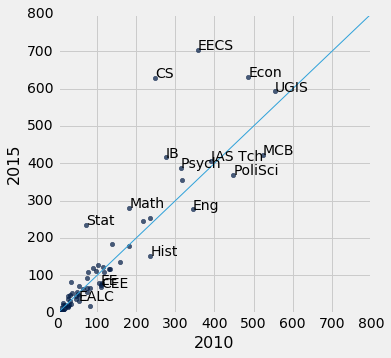

In [155]:
BAs_changes.select(["2015", "2010"]).scatter("2010")
plots.xlim(0,800)
plots.ylim(0,800)
plots.plot([0,800],[0,800], linewidth=1)
current = "2015"
prior = "2010"
for (note, dept) in dept_labels:
    plots.annotate(note, get_coords(BAs_changes, 'BAs', dept, "2010", "2015"))

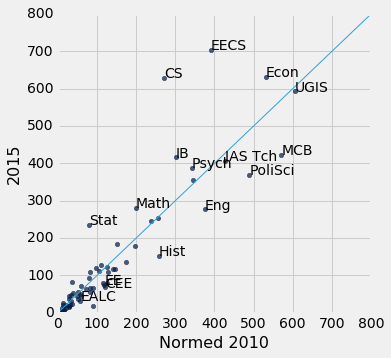

In [156]:
BAs_changes.select(["2015", "Normed 2010"]).scatter("Normed 2010")
plots.xlim(0,800)
plots.ylim(0,800)
plots.plot([0,800],[0,800], linewidth=1)
current = "2015"
prior = "2010"
for (note, dept) in dept_labels:
    plots.annotate(note, get_coords(BAs_changes, 'BAs', dept, "Normed 2010", "2015"))

### Majors

In [157]:
dept_majors_by_year = majors_by_year()
dept_majors_by_year.where('Year', 2016)

Year | L&S Undeclared | Electrical Eng & Computer Sci | Economics | Interdisc Social Science Pgms | Political Science | Env Sci, Policy, & Mgmt | UG Interdisciplinary Studies | Molecular & Cell Biology | Business | Psychology | Mechanical Engineering | Mathematics | English | Sociology | L&S Public Health | Integrative Biology | Chemistry | Chem & Biomolecular Eng | Statistics | Architecture | Nutritional Sciences & Tox | Bioengineering | Civil & Environmental Eng | Ag & Resource Econ & Pol | History | L&S Legal Studies | L&S Social Welfare | Physics | Engineering Science | Anthropology | Philosophy | Plant & Microbial Biology | Industrial Eng & Ops Research | Other Clg of Natural Res Pgms | Landscape Arch & Env Plan | Linguistics | Rhetoric | Materials Science & Eng | Music | Film and Media | Art Practice | Ethnic Studies | City & Regional Planning | Geography | Theater Dance & Perf Stds | Earth & Planetary Science | Spanish & Portuguese | Astronomy | History of Art | Nuclear Engineering | French | Gender & Womens Studies | Engineering Joint Programs | East Asian Lang & Culture | Comparative Literature | Classics | German | Near Eastern Studies | South & SE Asian Studies | L&S Chemistry | African American Studies | Italian Studies | L&S Envir Econ & Policy | Other Env Design Programs | Scandinavian | Slavic Languages & Literatures | Other Arts & Humanities Pgms | Other EVCP Programs | L&S Limited | Other Physical Sciences Pgms | Other Social Sciences Programs
2016 | 8969           | 2279                          | 1139      | 937                           | 834               | 816                     | 797                          | 793                      | 673      | 628        | 577                    | 576         | 550     | 502       | 493               | 484                 | 424       | 420                     | 357        | 330          | 291                        | 290            | 288                       | 285                      | 283     | 281               | 277                | 272     | 216                 | 214          | 183        | 172                       | 144                           | 138                           | 135                       | 122         | 121      | 115                     | 107   | 99             | 98           | 97             | 93                       | 92        | 88                        | 86                        | 79                   | 75        | 70             | 52                  | 46     | 44                      | 43                         | 39                        | 32                     | 24       | 24     | 22                   | 19                       | 18            | 17                       | 13              | 13                      | 6                         | 6            | 5                              | 1                            | 1                   | 0           | 0                            | 0

In [158]:
pseudo_dept_majors_by_year = adj_eng_majors_by_year.select(['Year', 'Computer Science', 'Electrical Eng'])

majors_changes = convert_by_year_to_change(dept_majors_by_year, "majors", 5, pseudo_dept_majors_by_year)
majors_changes

majors                        | 2011    | 2016    | Growth  | Rel Growth | Normed 2011 | Normed Rel Growth
Computer Science              | 849.838 | 2107.99 | 1258.16 | 2.48047    | 885.132     | 2.38156
Electrical Eng & Computer Sci | 1232    | 2279    | 1047    | 1.84984    | 1283.17     | 1.77608
L&S Undeclared                | 8289    | 8969    | 680     | 1.08204    | 8633.25     | 1.03889
Economics                     | 939     | 1139    | 200     | 1.21299    | 977.998     | 1.16462
Mathematics                   | 384     | 576     | 192     | 1.5        | 399.948     | 1.44019
L&S Public Health             | 319     | 493     | 174     | 1.54545    | 332.248     | 1.48383
Statistics                    | 201     | 357     | 156     | 1.77612    | 209.348     | 1.7053
Interdisc Social Science Pgms | 828     | 937     | 109     | 1.13164    | 862.388     | 1.08652
Landscape Arch & Env Plan     | 39      | 135     | 96      | 3.46154    | 40.6197     | 3.32351
Ag & Resource Econ & Pol      | 191     | 285     | 94      | 1.49215    | 198.932     | 1.43265
... (59 rows omitted)

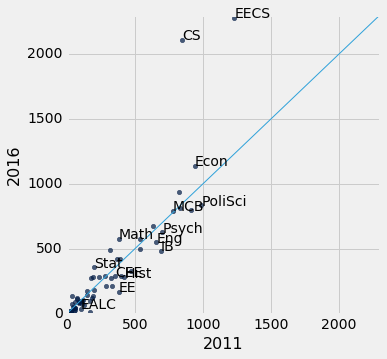

In [159]:
majors_changes.select(["2016", "2011"]).scatter("2011")
mmax = 2300
plots.xlim(0,mmax)
plots.ylim(0,mmax)
plots.plot([0,mmax],[0,mmax], linewidth=1)
for (note, dept) in dept_labels:
    if majors_changes.where('majors', dept).num_rows > 0:
        plots.annotate(note, get_coords(majors_changes, 'majors', dept, "2011", "2016"))

In [160]:
dept_credits_by_year = credits_by_year()
dept_credits_by_year.where('Year', 2016)

Year | Electrical Eng & Computer Sci | Mathematics | Business | Law   | Economics | Molecular & Cell Biology | Chemistry | English | Sociology | Public Health | Psychology | Physics | Statistics | Political Science | History | Env Sci, Policy, & Mgmt | UGIS-UG Interdisc Studies | Anthropology | Intl & Area Stds Grad Grp | Integrative Biology | East Asian Lang & Culture | Music | Education | Mechanical Engineering | Philosophy | Civil & Environmental Eng | Public Policy | Nutritional Science & Tox | Architecture | Engineering Science | Spanish & Portuguese | Optometry | Geography | French | Social Welfare | Ethnic Studies | South & SE Asian Studies | Theater Dance & Perf Stds | Industrial Eng & Ops Research | L&S Undeclared | Rhetoric | Asian Studies Grad Grp | Linguistics | Gender & Womens Studies | African American Studies | Chem & Biomolecular Eng | Earth & Planetary Science | Film and Media | Near Eastern Studies | City & Regional Planning | Astronomy | Classics | History of Art | German | Bioengineering | Ag & Resource Econ & Pol | Art Practice | Other Social Sciences | Physical Education | Comparative Literature | Landscape Arch & Env Plan | Ethnic Studies Grad Grp | Library & Info Studies | Information | Journalism | Plant & Microbial Biology | Other Env Design Programs | Slavic Languages & Lit | Materials Science & Eng | Italian Studies | Vision Science Grad Grp | Scandinavian | Energy & Resources Group | Grad group in development eng | Neuroscience Grad Program | Hlth & Med Sci Grad Grp | Nuclear Engineering | Multiple | Demography | Buddhist Studies Grad Grp | Other CNR Programs | None | Jewish Studies Program | Other Bio Sciences Pgms | Biophysics Grad Grp | Folklore Grad Grp | Computer Biochem Grad Grp | Anc Hist Med Arc Grad Grp
2016 | 83816                         | 67255       | 65312    | 42720 | 37720     | 37489                    | 33522     | 32798   | 29533     | 29143         | 29120      | 27184   | 25900      | 25804.5           | 23746.5 | 19545                   | 18131                     | 17544        | 15637                     | 15468               | 15369                     | 15107 | 14138     | 13739                  | 11663      | 10729                     | 10661         | 10226                     | 10152        | 9459                | 9320                 | 8886.5    | 8646      | 8427   | 8293           | 8024           | 7714                     | 7395                      | 7259                          | 7107           | 6986     | 6949                   | 6582        | 6452.5                  | 6450                     | 6357                    | 6144                      | 6117           | 5885                 | 5829                     | 5816      | 5809     | 5507           | 5450   | 5269           | 5263                     | 5186         | 5141                  | 5009               | 4794                   | 4760                      | 4241                    | 4011                   | 3807        | 3417.5     | 3306.5                    | 3297                      | 3075                   | 2852                    | 2717            | 2253.5                  | 2115         | 2031                     | 1955                          | 1861                      | 1545                    | 1479                | 1023     | 739        | 722                       | 379                | 350  | 235                    | 181                     | 66                  | 48                | 19                        | 18

In [161]:
#pseudo_dept_credits_by_year = eng_credits_by_year.select(['Year', 'Computer Science', 'Electrical Eng'])

#credits_changes = convert_by_year_to_change(dept_credits_by_year, "credits", 5, pseudo_dept_credits_by_year)
#credits_changes

In [162]:
#credits_changes.select(["2016", "2011"]).scatter("2011")
#mmax = 2300
#plots.xlim(0,mmax)
#plots.ylim(0,mmax)
#plots.plot([0,mmax],[0,mmax], linewidth=1)
#for (note, dept) in dept_labels:
#    if credits_changes.where('credits', dept).num_rows > 0:
#        plots.annotate(note, get_coords(credits_changes, 'credits', dept, "2011", "2016"))

<a id="section_fraction"></a>

# Fraction of degrees

It is useful to view such measures of productivity in the larger campus context. There are 1510 FTE campus wide with EECS at 90.5 FTE, so as a department it is 6% of the FTE.  In the 80's peak it reached 8.4% of the Bachellors output, but the total output was considerably smaller then.  Today it now exceeds 9%.  But the rate is increasing, so the fraction of students is considerably higher.

In [163]:
# Fraction of FTE
EECS_fte/total_fte, CS_fte/total_fte

(0.05992385366661148, 0.031120675384870049)

In [164]:
Bach_grad = EECS_grads_by_year.select(['Year', 'Bachelor'])
Bach_grad.relabel('Bachelor', 'EECS')
Bach_grad['UCB'] = UCB_grads_by_year['Bachelor']
#Bach_grad['UCB'] = Prorated_by_year['Bachelor']
Bach_grad['Fraction EECS+CS'] = Bach_grad['EECS'] / Bach_grad['UCB']
Bach_grad.set_format('Fraction EECS+CS', PercentFormatter)
#Bach_grad.show() #uncomment to see all values

Year | EECS | UCB  | Fraction EECS+CS
1984 | 406  | 5071 | 8.01%
1985 | 317  | 4814 | 6.58%
1986 | 352  | 5290 | 6.65%
1987 | 355  | 5547 | 6.40%
1988 | 322  | 5975 | 5.39%
1989 | 265  | 6015 | 4.41%
1990 | 321  | 6082 | 5.28%
1991 | 281  | 5725 | 4.91%
1992 | 318  | 6454 | 4.93%
1993 | 357  | 6274 | 5.69%
... (22 rows omitted)

(0, 0.1)

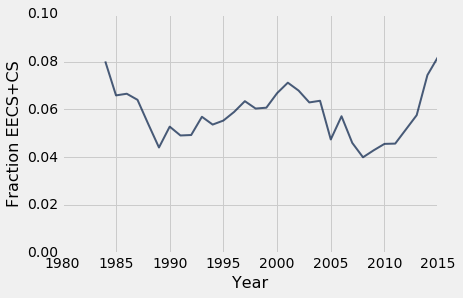

In [165]:
Bach_grad.select(['Year', 'Fraction EECS+CS']).plot('Year')
plots.ylim(0,0.1)

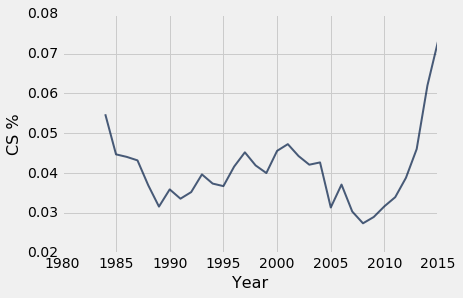

In [166]:
cs_BA_fraction = UCB_grads_by_year.select(['Year', 'Bachelor']).with_column('Computer Science', adj_eng_degrees_by_year['Computer Science'])
cs_BA_fraction['CS %']= cs_BA_fraction['Computer Science']/cs_BA_fraction['Bachelor']
cs_BA_fraction.select(['Year', 'CS %']).plot('Year')

<a id="section_related"></a>

# Degrees in related fields

In considering this broader view, it is valuable to consider our fellow travelors. 
* Statistics has long had a large instructional program, but starting from the fall off of the internet boom they have seen a profound growth of majors, which has taken off since the emergence of data science in 2010.  A very large fraction of these are double majors.  Historically there was strong double major affinity among statistics, economics, and applied math.  Now all three double with L&S CS.
* Information continues to produce a handfull of PhDs and zero Bachelors, but with the on-line MIDS have return to producing about 50 masters per year.
* Mathematics has experienced its own booms and busts, generally tracking computing, but smaller in scale.  The concentrations of pure math, applied math, and math for teachers are not broken out in the data.

These trends are reflected in graduates salary data.

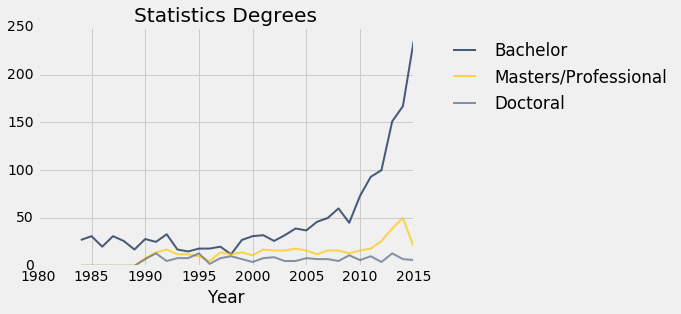

In [167]:
Stats_grads_by_year = grad_table_by_year(['Statistics'])
sort_cols(Stats_grads_by_year).plot('Year')
plots.title("Statistics Degrees")

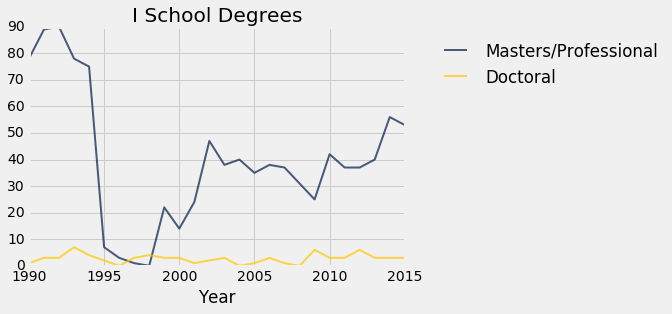

In [168]:
sort_cols(grad_table_by_year(['Information','Library & Info Studies'])).plot('Year')
plots.title("I School Degrees")

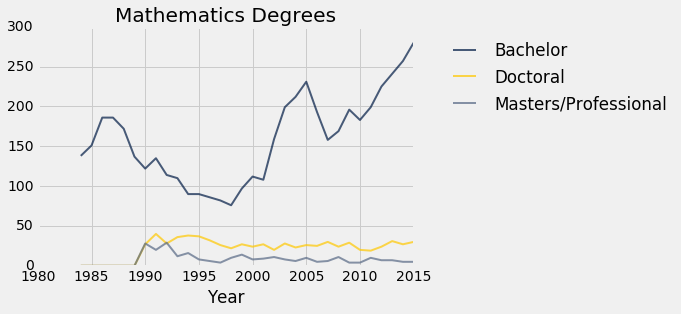

In [169]:
sort_cols(grad_table_by_year(['Mathematics'])).plot('Year')
plots.title("Mathematics Degrees")

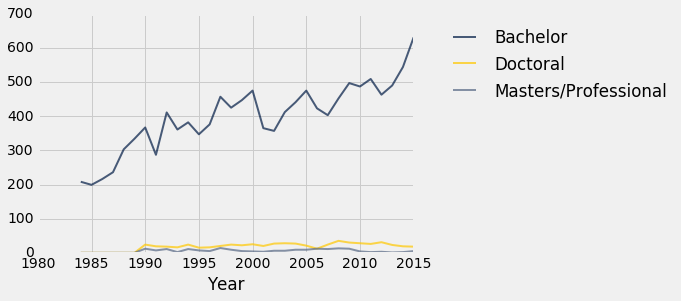

In [170]:
grad_table_by_year(['Economics']).plot('Year')

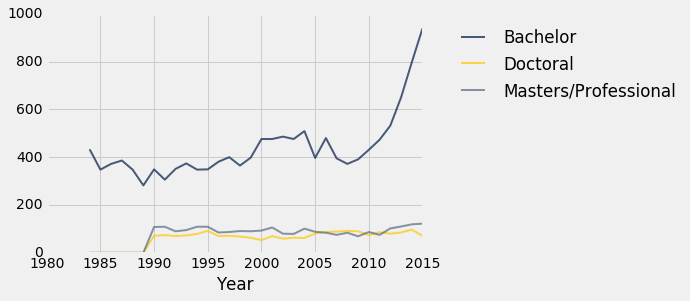

In [171]:
CIS_grads_by_year = grad_table_by_year(['L&S Computer Science', 'Electrical Eng & Computer Sci', 'Statistics'])
CIS_grads_by_year.plot('Year')

<a id="section_double"></a>

# Double majors

This data set gives a limited view into the prevalence od double majors.  The `Degrees` column represents
the number of degrees conferred by each unit and the `Prorated` appears to prorate the degrees earned by an
individual student over the units they receive degrees from.  So the sum of `Prorated` should be the number of actual students.  Looking at the difference in the two gives a sense of the prevalence of multiple majors.  However, there are some triple majors, so the difference slightly over estimates the number of students when looking at the student body as a whole.  

From this we can see that the number of double majors has increased from 6% to about 12%, so it is not rare.

In looking at an individual department, the number of students with double majors should exceed twice the difference, because a double major counts 1/2 to the prorated and 1 to the degrees.

* For Statistics a majority of the majors are double majors.  The fraction has 
always been high, but it shot up as the program started to grow in 2006.  As the program has grown
the double majors have settled some, but remain high and vastly different from the
student population as a whole.  With the growth, 130 of 250 graduates are double majors.
* For L&S Computer Science double major at twice the university rate and half the statistics
rates.  The fraction has grown along with the size of the program, resulting in nearly
a hundred double majors.  Many of these are doubles with statistics.  Historically, statistics,
economics and applied math common double (and triple) combinations.  Recently, all three 
double with computer science.  
* EECS double majors are relatively rare, a fraction of the campus rate.  A modest number of students graduate in joint-major programs.

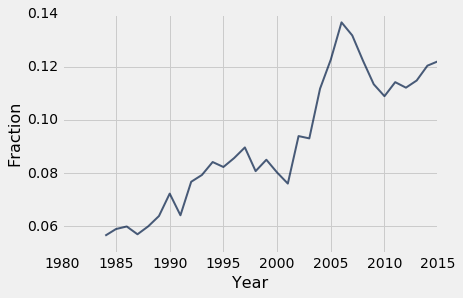

In [172]:
doubles = UCB_grads_by_year.select(['Year', 'Bachelor'])
doubles['Prorated'] =  UCB_prorated_by_year['Bachelor']
doubles['Multi'] = doubles['Bachelor'] - doubles['Prorated']
doubles['Fraction'] = doubles['Multi'] / doubles['Prorated']
doubles.set_format('Fraction', PercentFormatter)
doubles.plot('Year', 'Fraction')

In [173]:
def doubles_by_year(depts, degrees):
    if type(depts) is str:
        rows = degrees["Department"] == depts
    else:
        rows = degrees["Department"] == depts[0]
        for dept in depts[1:]:
            rows = np.logical_or(rows, degrees["Department"] == dept)   
    BAs = degrees.where(rows).where('DegLvl', 1).select(['Year', 'Grads', 'Prorated']).group('Year',sum)
    BAs['Multi'] = 2*(BAs['Grads sum'] - BAs['Prorated sum'])
    BAs['Fraction'] = BAs['Multi'] / BAs['Grads sum']
    BAs.set_format('Fraction', PercentFormatter)
    return BAs

In [174]:
doubles_by_year(['Statistics'], degrees).show()

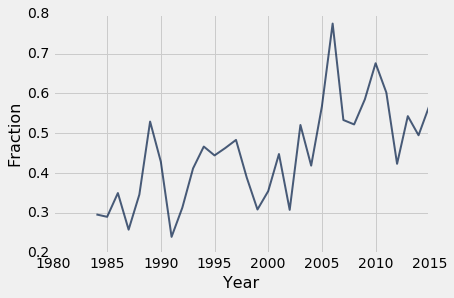

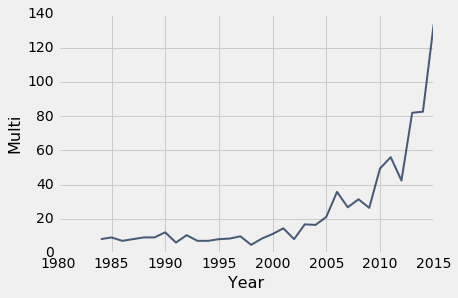

In [175]:
doubles_by_year(['Statistics'], degrees).plot('Year', 'Fraction')
doubles_by_year(['Statistics'], degrees).plot('Year', 'Multi')

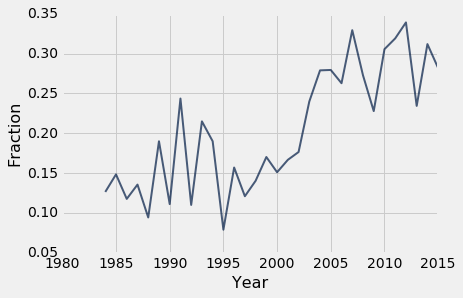

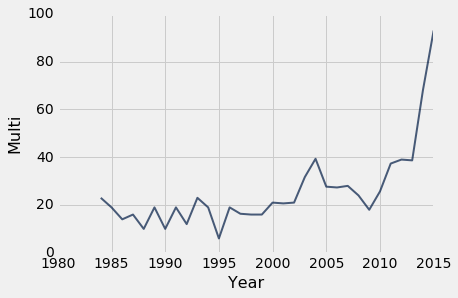

In [176]:
doubles_by_year(['L&S Computer Science'], degrees).plot('Year', 'Fraction')
doubles_by_year(['L&S Computer Science'], degrees).plot('Year', 'Multi')

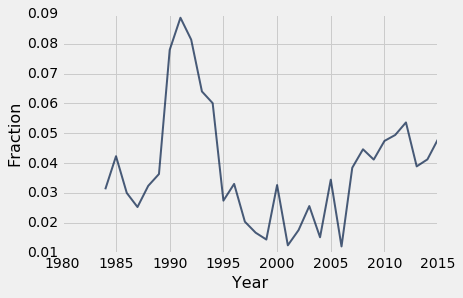

In [177]:
doubles_by_year(['Electrical Eng & Computer Sci'], degrees).plot('Year', 'Fraction')

<a id="section_stem"></a>

# STEM Fields Comparison



Current national studies examine computing in relation to other large STEM fields.  

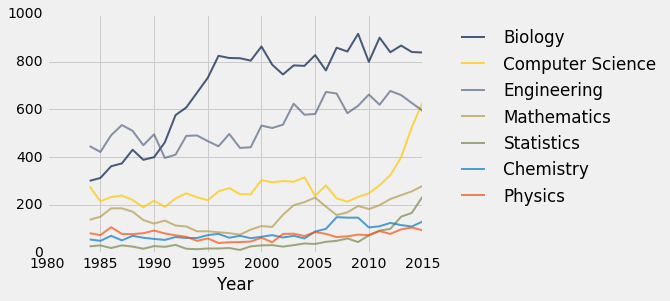

In [178]:
stem_BAs_by_year = BAs_by_year.select(['Year', 'Mathematics', 'Statistics', 'Physics'])
stem_BAs_by_year['Computer Science'] = pseudo_dept_BAs_by_year['Computer Science']
stem_BAs_by_year['Biology'] = BAs_by_year['Integrative Biology'] + BAs_by_year['Molecular & Cell Biology']
stem_BAs_by_year['Chemistry'] = BAs_by_year['Chemistry'] + BAs_by_year['L&S Chemistry']
edepts = ['Bioengineering',
       'Civil & Environmental Eng',
       'Engineering Science', 'Industrial Eng & Ops Research',
       'Materials Science & Eng', 'Mechanical Engineering',
       'Nuclear Engineering', 'Ocean Eng Grad Grp']
stem_BAs_by_year['Engineering'] = sum([BAs_by_year[dept] for dept in edepts]) + pseudo_dept_BAs_by_year['Electrical Eng']
sort_cols(stem_BAs_by_year).plot('Year')

<a id="section_breakout"></a>

# Breakout of departments of other divisions

In [179]:
list(np.unique(degrees['Division']))

['Clg of Chemistry',
 'Clg of Engineering',
 'Clg of Env Design',
 'Clg of Natural Resources',
 'Goldman School Pub Pol',
 'Grad School of Education',
 'Grad School of Journalism',
 'Graduate',
 'Haas School of Business',
 'I School',
 'L&S Administered Programs',
 'L&S Arts & Humanities',
 'L&S Biological Sciences',
 'L&S Math & Phys Sciences',
 'L&S Social Sciences',
 'L&S Undeclared',
 'L&S Undergrad Studies',
 'Other EVCP Programs',
 'School of Law',
 'School of Optometry',
 'School of Public Health',
 'School of Social Welfare']

In [180]:
def show_division(division):
    div_grads(division, 1, True, True).plot('Year')
    _ = plots.title(division + " BAs")
    div_majors(division, True, True).plot('Year')
    _ = plots.title(division + " majors")
    div_credits(division).plot('Year')
    _ = plots.title(division + " SCHs")
    div_grads(division, 2).plot('Year')
    _ = plots.title(division + " MAs")
    div_grads(division, 3).plot('Year')
    _ = plots.title(division + " PhDs")

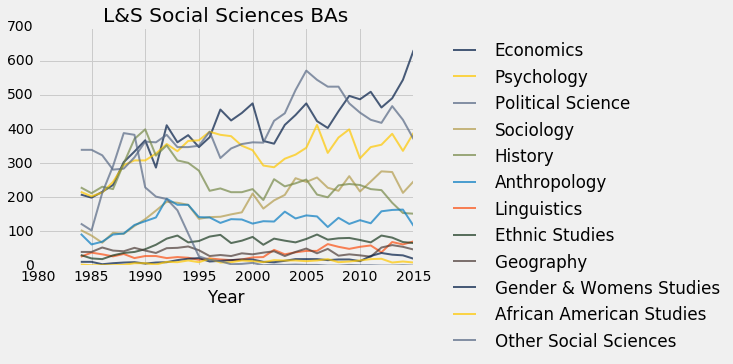

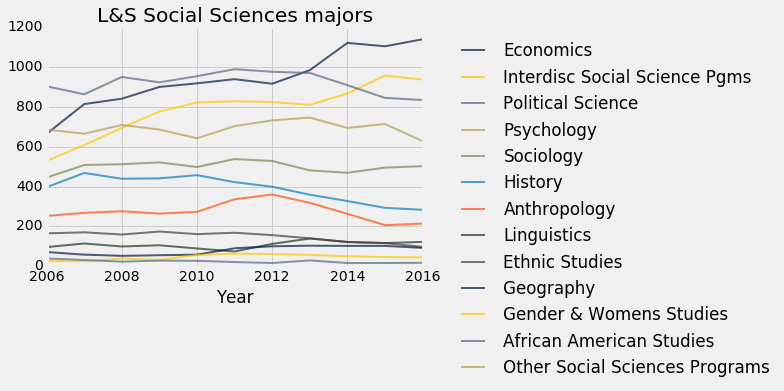

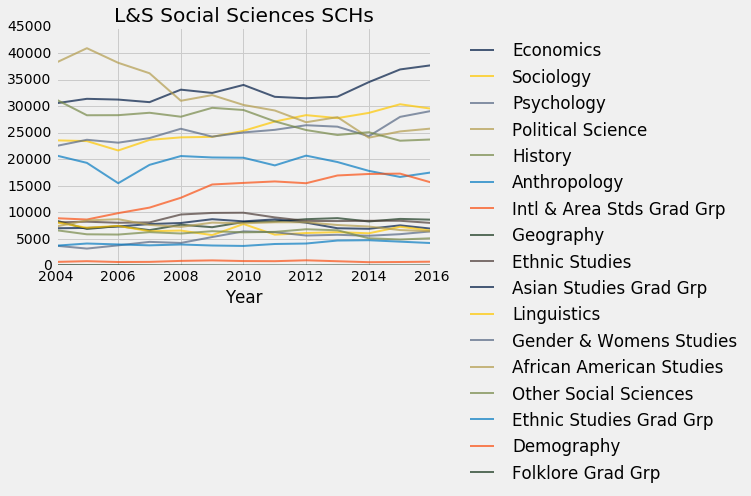

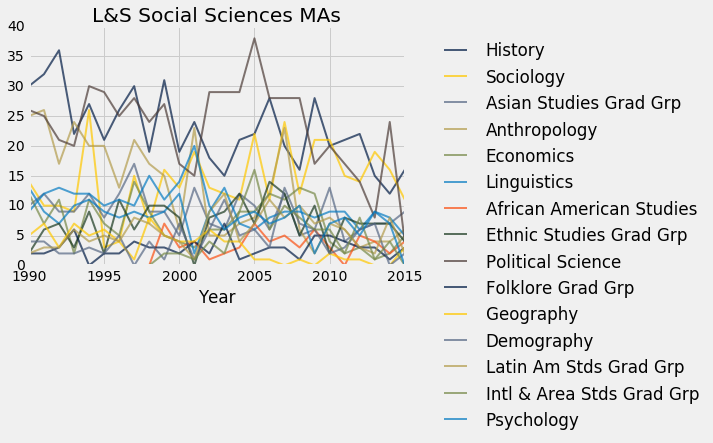

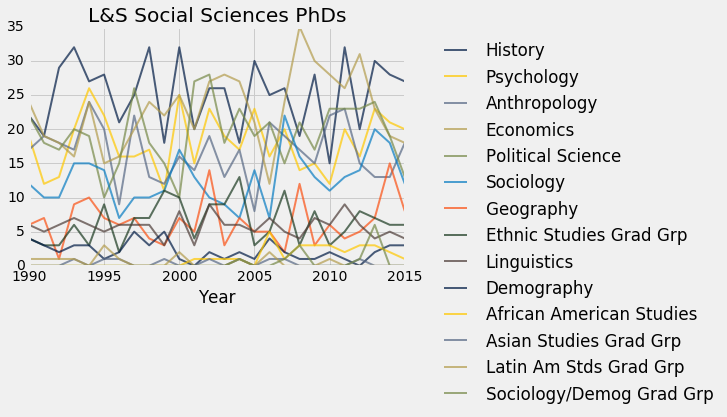

In [181]:
show_division('L&S Social Sciences')

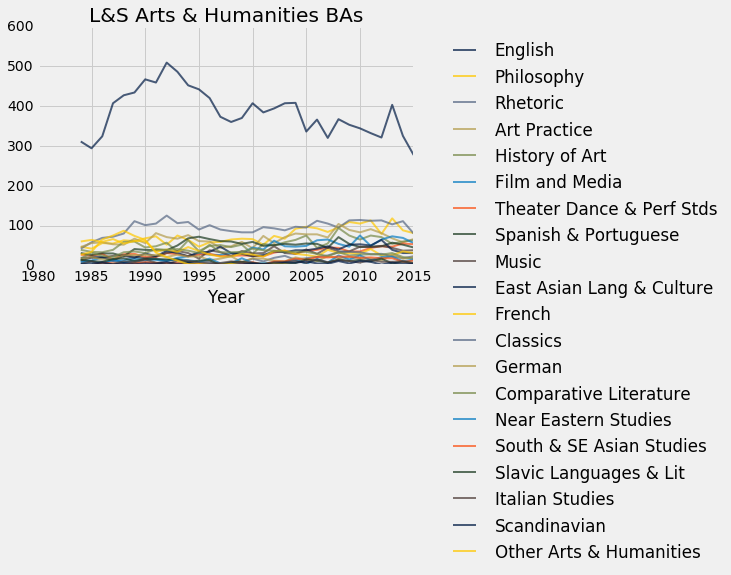

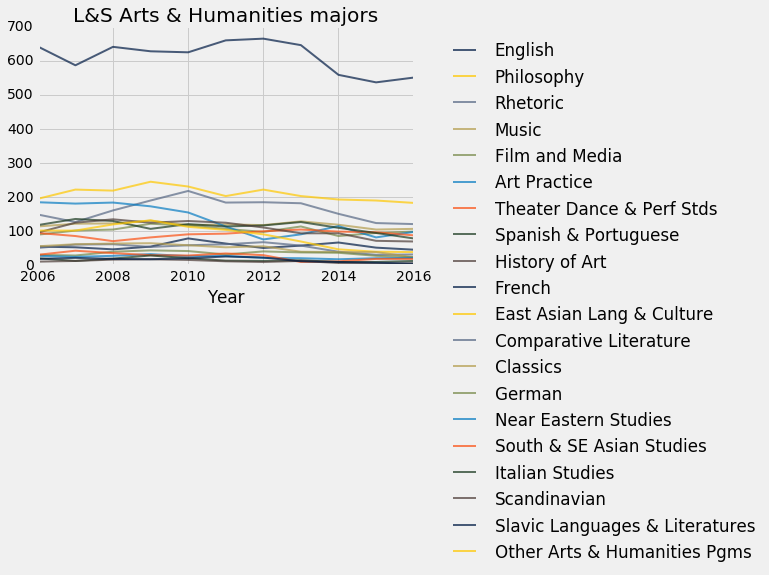

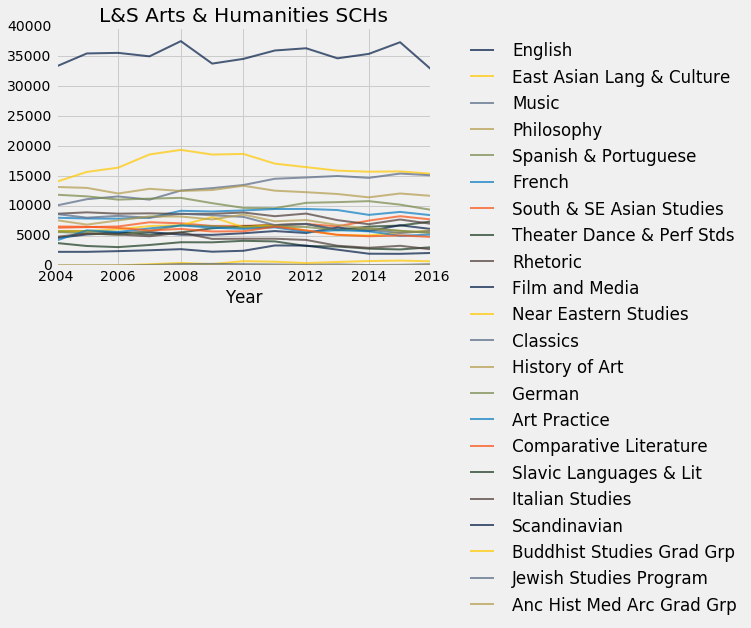

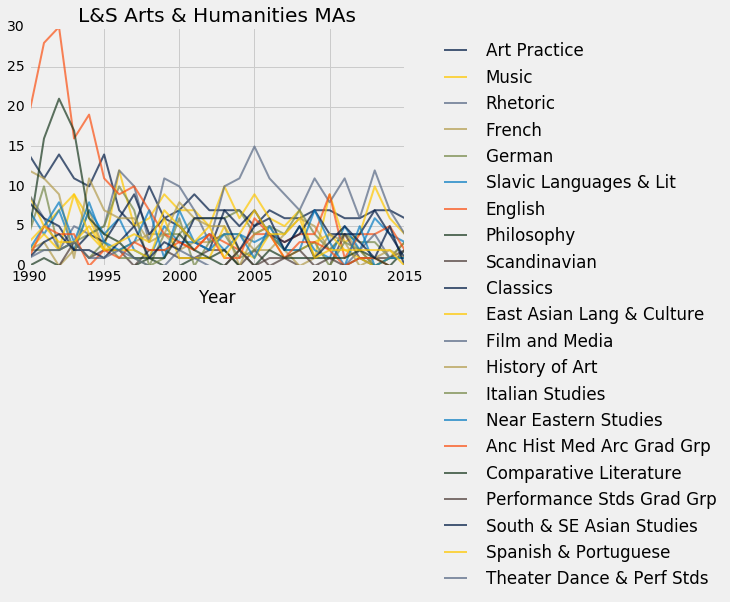

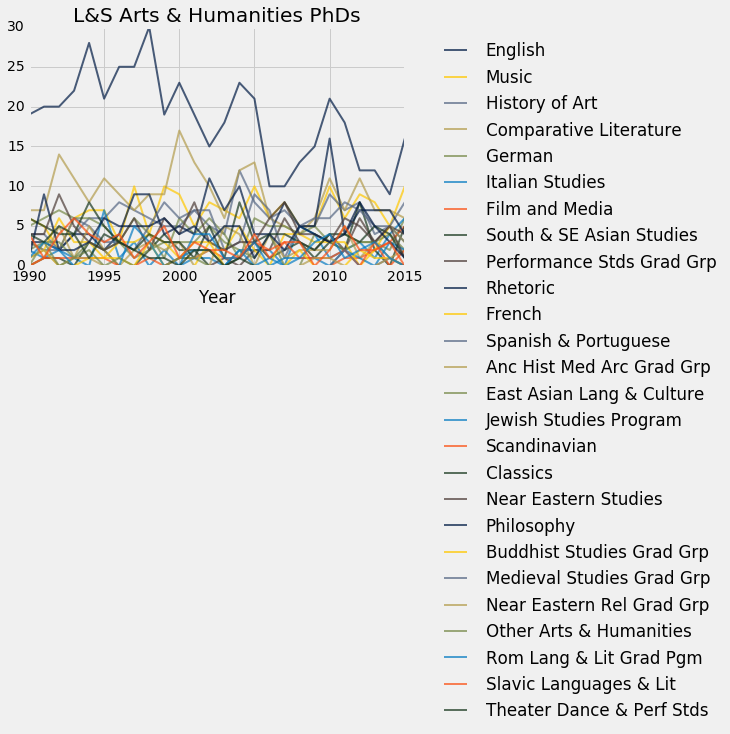

In [182]:
show_division('L&S Arts & Humanities')

In [183]:
#show_division('School of Public Health')